<a href="https://colab.research.google.com/github/SanjivMehra26/Generative-AI/blob/main/Coding_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-sml


/bin/bash: line 1: nvidia-sml: command not found


In [ ]:
!nvidia-smi

Mon Nov 11 10:53:50 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
import pdb

def processname(name):
  pdb.set_trace() # c for comtinue, l from seeing the line , n for next line
  when = "today"
  print(name,'is using google colab',when)

processname('javier')

> <ipython-input-15-fb74a2c99318>(5)processname()
      3 def processname(name):
      4   pdb.set_trace() # c for comtinue, l from seeing the line , n for next line
----> 5   when = "today"
      6   print(name,'is using google colab',when)
      7 

ipdb> c
javier is using google colab today


In [ ]:
# import the libraries

import torch, pdb
from torch.utils.data import DataLoader
from torch import nn
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

In [ ]:
#visualization function
def show(tensor, ch=1, size=(28,28),num=16):
  #tensor: 128 (Batch size) * 784 (28*28)
  data=tensor.detach().cpu().view(-1,ch,*size) # 128 x 1 x 28 x 28
  grid = make_grid(data[:num], nrow=4).permute(1,2,0)   # 1 x 28 x 28  = 28 x 28 x 1
  plt.imshow(grid)
  plt.show()

In [ ]:
# setup of the main parameters and hyperparameters

epochs = 500
cur_step = 0
info_step = 300
mean_gen_loss = 0
mean_disc_loss = 0

z_dim = 64
lr = 0.00001
loss_func = nn.BCEWithLogitsLoss()

bs = 128
device = 'cuda'

dataloader = DataLoader(MNIST('.',download=True,transform=transforms.ToTensor()),shuffle=True,batch_size=bs)

# number if steps = 60000 / 128 =
# 60K number of image MNIST has in package

In [ ]:
# declare our models

# Generator

def genBlock(inp,out):
  return nn.Sequential(
      nn.Linear(inp,out),
      nn.BatchNorm1d(out),
      nn.ReLU(inplace=True)
  )


class Generator(nn.Module):
  def __init__(self,z_dim=64,i_dim=784,h_dim=128):
    super().__init__()
    self.gen = nn.Sequential(
        genBlock(z_dim,h_dim),
        genBlock(h_dim,h_dim*2),
        genBlock(h_dim*2,h_dim*4),
        genBlock(h_dim*4,h_dim*8),
        nn.Linear(h_dim*8,i_dim),
        nn.Sigmoid(),
    )

  def forward(self,noise):
    return self.gen(noise)

def gen_noise(number,z_dim):
  return torch.randn(number,z_dim).to(device)

In [ ]:
## Discriminator
def discBlock(inp, out):
  return nn.Sequential(
      nn.Linear(inp, out),
      nn.LeakyReLU(0.2)
  )

class Discriminator(nn.Module):
  def __init__(self, i_dim=784, h_dim=256):
    super().__init__()
    self.disc=nn.Sequential(
        discBlock(i_dim, h_dim*4), # 784, 1024
        discBlock(h_dim*4, h_dim*2), # 1024, 512
        discBlock(h_dim*2, h_dim), # 512, 256
        nn.Linear(h_dim, 1) # 256, 1
    )

  def forward(self, image):
      return self.disc(image)

In [ ]:
gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(),lr=lr)
disc = Discriminator().to(device)
disc_opt = torch.optim.Adam(disc.parameters(),lr=lr)


In [ ]:
gen

Generator(
  (gen): Sequential(
    (0): Sequential(
      (0): Linear(in_features=64, out_features=128, bias=True)
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Linear(in_features=128, out_features=256, bias=True)
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (2): Sequential(
      (0): Linear(in_features=256, out_features=512, bias=True)
      (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (3): Sequential(
      (0): Linear(in_features=512, out_features=1024, bias=True)
      (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (4): Linear(in_features=1024, out_features=784, bias=True)
    (5): Sigmoid()
  )
)

In [ ]:
disc

Discriminator(
  (disc): Sequential(
    (0): Sequential(
      (0): Linear(in_features=784, out_features=1024, bias=True)
      (1): LeakyReLU(negative_slope=0.2)
    )
    (1): Sequential(
      (0): Linear(in_features=1024, out_features=512, bias=True)
      (1): LeakyReLU(negative_slope=0.2)
    )
    (2): Sequential(
      (0): Linear(in_features=1568, out_features=256, bias=True)
      (1): LeakyReLU(negative_slope=0.2)
    )
    (3): Linear(in_features=256, out_features=1, bias=True)
  )
)

torch.Size([128, 1, 28, 28]) torch.Size([128])
tensor([2, 8, 1, 8, 2, 2, 8, 9, 1, 0])


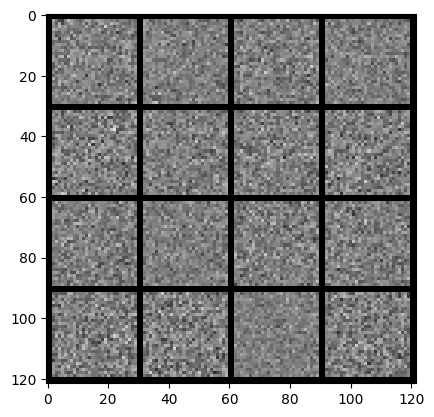

In [ ]:
x,y = next(iter(dataloader))
print(x.shape,y.shape)
print(y[:10])

noise = gen_noise(bs,z_dim)
fake = gen(noise)
show(fake)

In [ ]:
# calculating the loss

# generator loss
def calc_gen_loss(loss_func, gen, disc, number, z_dim):
   noise = gen_noise(number, z_dim)
   fake = gen(noise)
   pred = disc(fake)
   targets=torch.ones_like(pred)
   gen_loss=loss_func(pred,targets)

   return gen_loss


def calc_disc_loss(loss_func, gen, disc, number, real, z_dim):
   noise = gen_noise(number, z_dim)
   fake = gen(noise)
   disc_fake = disc(fake.detach())
   disc_fake_targets=torch.zeros_like(disc_fake)
   disc_fake_loss=loss_func(disc_fake, disc_fake_targets)

   disc_real = disc(real)
   disc_real_targets=torch.ones_like(disc_real)
   disc_real_loss=loss_func(disc_real, disc_real_targets)

   disc_loss=(disc_fake_loss+disc_real_loss)/2

   return disc_loss


  0%|          | 0/469 [00:00<?, ?it/s]

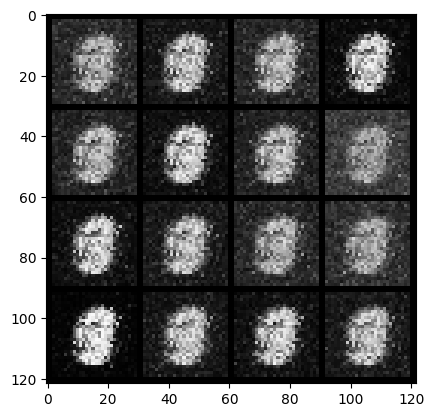

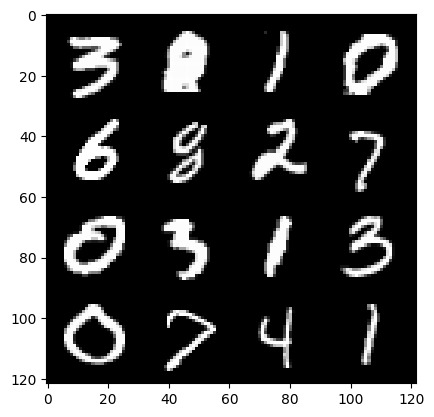

0: step 300 / Gen loss: 1.9648053958018614 / disc_loss: 0.33526686780154696


  0%|          | 0/469 [00:00<?, ?it/s]

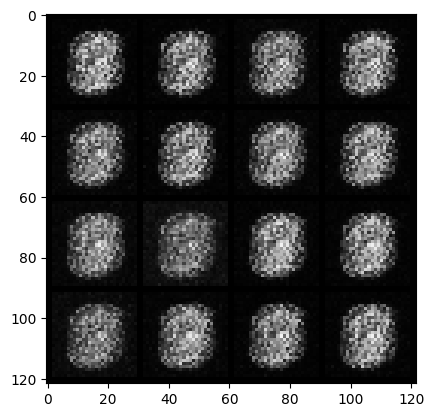

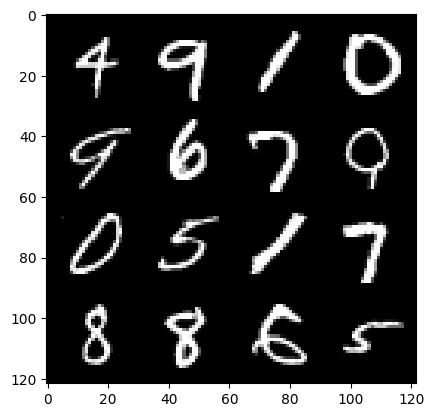

1: step 600 / Gen loss: 3.526897433598836 / disc_loss: 0.11386233538389211


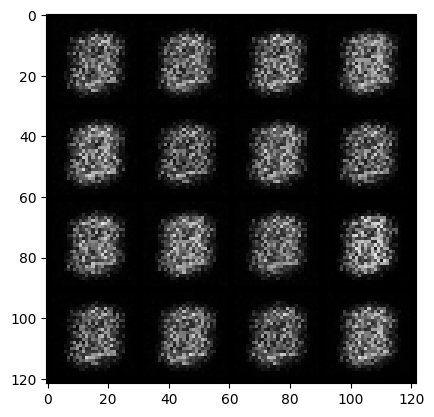

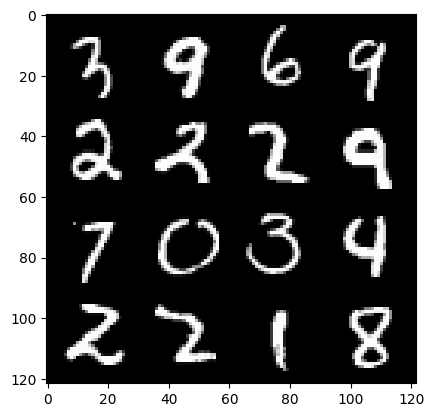

1: step 900 / Gen loss: 3.4469005791346254 / disc_loss: 0.0539375210056702


  0%|          | 0/469 [00:00<?, ?it/s]

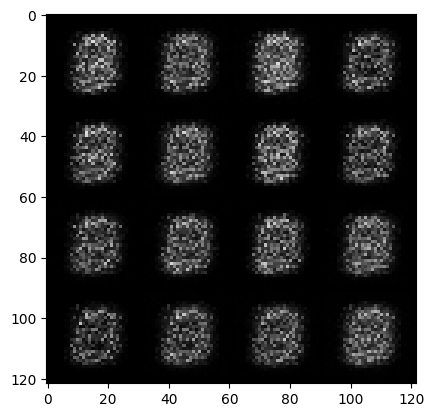

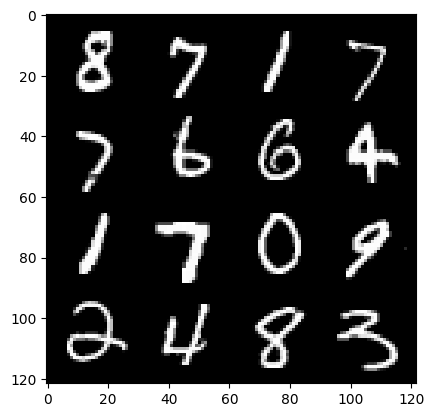

2: step 1200 / Gen loss: 3.432513256867726 / disc_loss: 0.039136540144681965


  0%|          | 0/469 [00:00<?, ?it/s]

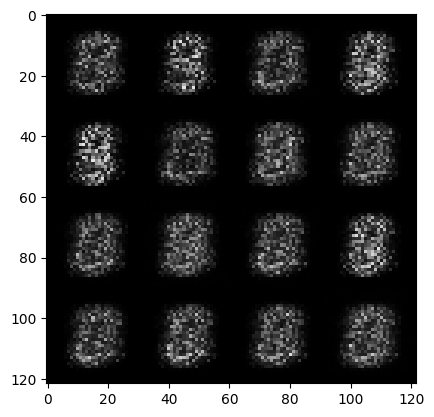

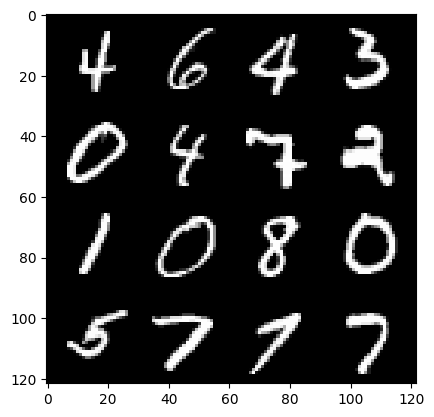

3: step 1500 / Gen loss: 3.4286470961570754 / disc_loss: 0.04083438013369836


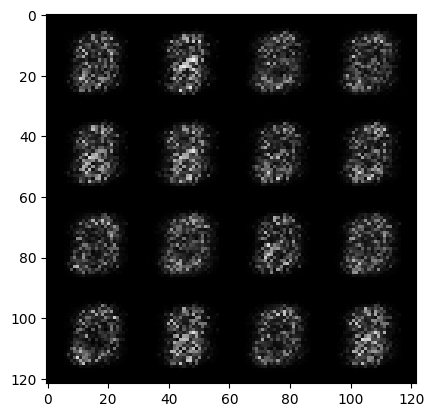

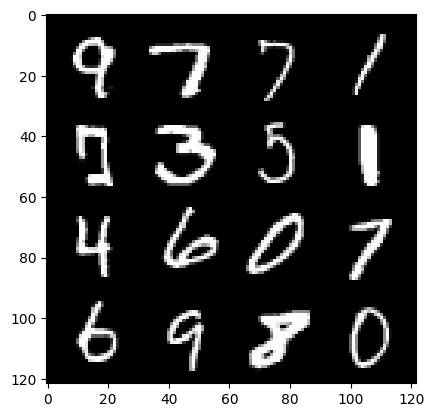

3: step 1800 / Gen loss: 3.507089542547862 / disc_loss: 0.04308656738450132


  0%|          | 0/469 [00:00<?, ?it/s]

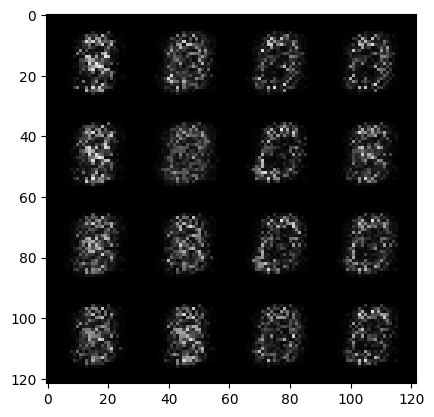

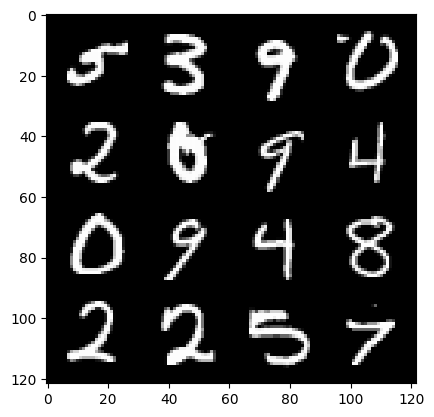

4: step 2100 / Gen loss: 3.67817835330963 / disc_loss: 0.03574746008962393


  0%|          | 0/469 [00:00<?, ?it/s]

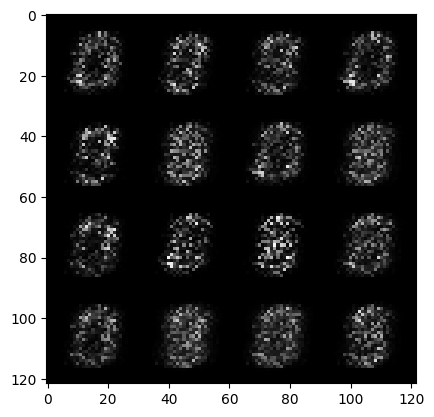

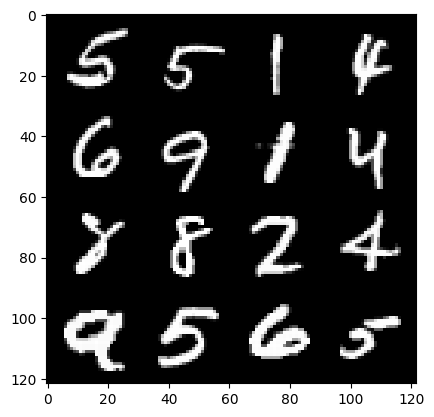

5: step 2400 / Gen loss: 4.215437024434404 / disc_loss: 0.026252641761675466


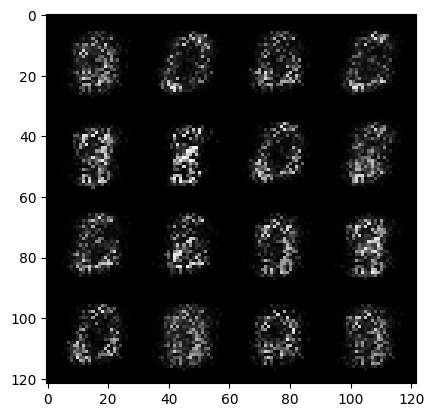

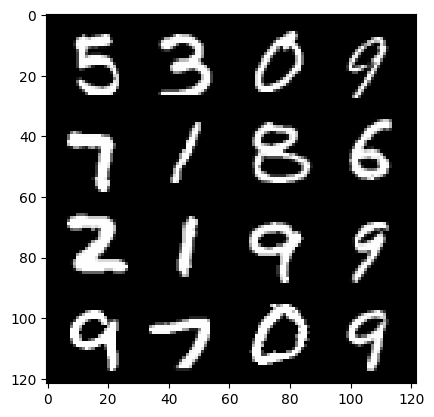

5: step 2700 / Gen loss: 4.4177883323033615 / disc_loss: 0.022664833369975282


  0%|          | 0/469 [00:00<?, ?it/s]

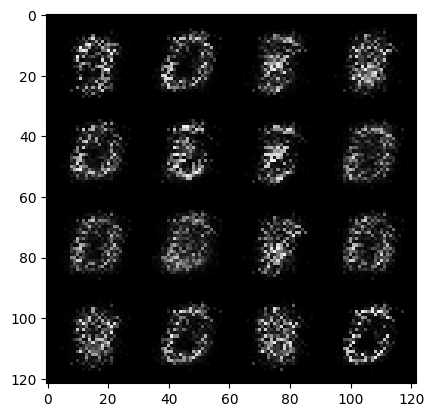

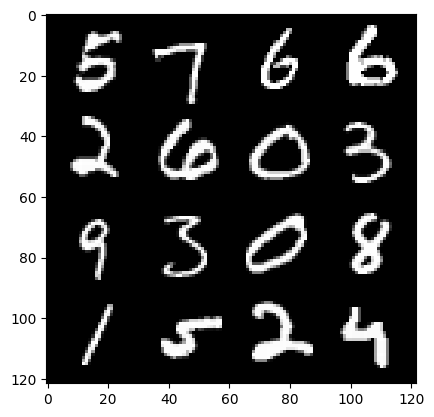

6: step 3000 / Gen loss: 4.716024599075318 / disc_loss: 0.020085916739578057


  0%|          | 0/469 [00:00<?, ?it/s]

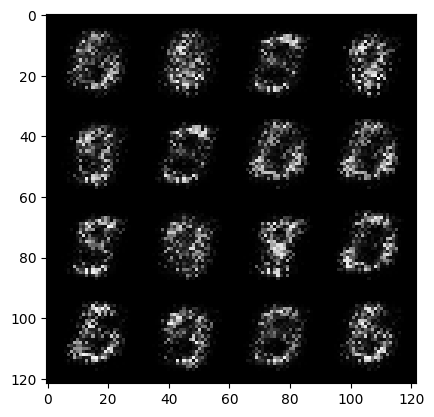

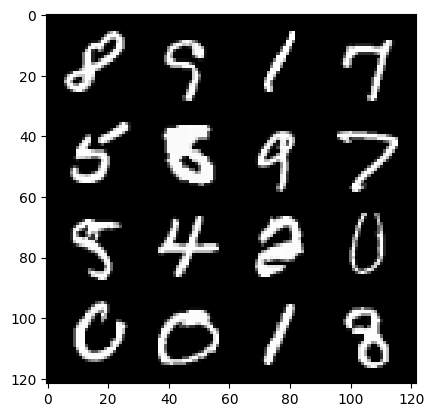

7: step 3300 / Gen loss: 5.11395629088084 / disc_loss: 0.021798673629139866


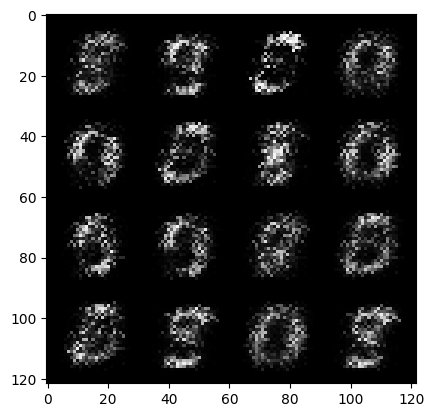

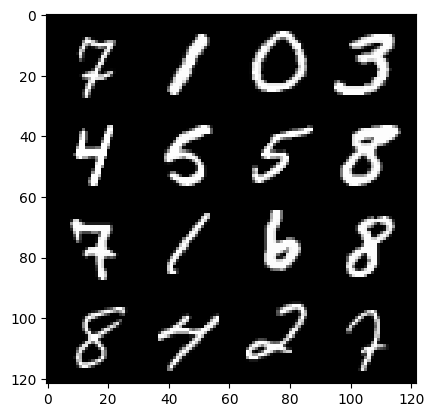

7: step 3600 / Gen loss: 5.543191892306011 / disc_loss: 0.02213525135380528


  0%|          | 0/469 [00:00<?, ?it/s]

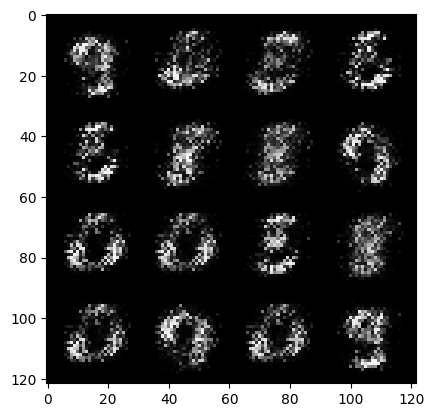

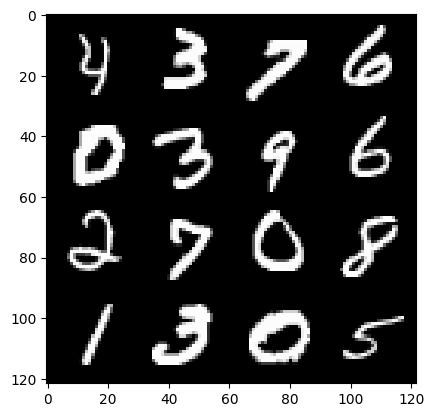

8: step 3900 / Gen loss: 5.712521905899051 / disc_loss: 0.02311781688903771


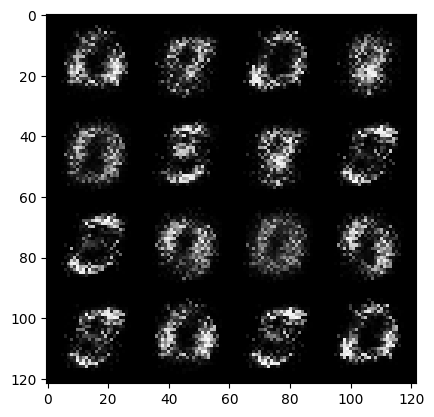

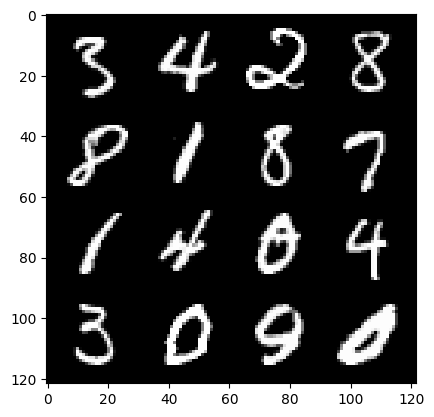

8: step 4200 / Gen loss: 5.472619357109068 / disc_loss: 0.023837374250094096


  0%|          | 0/469 [00:00<?, ?it/s]

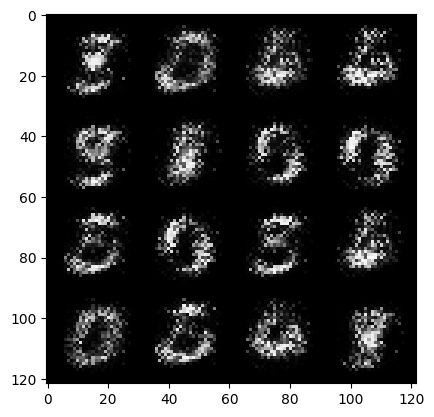

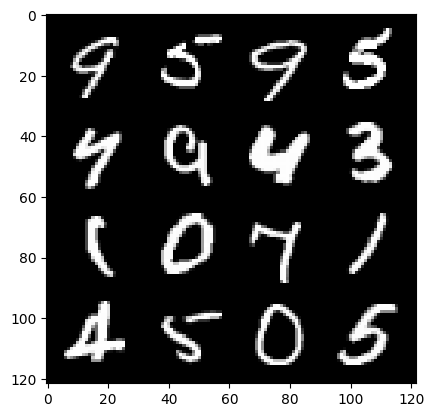

9: step 4500 / Gen loss: 5.81880422115326 / disc_loss: 0.018601727949765823


  0%|          | 0/469 [00:00<?, ?it/s]

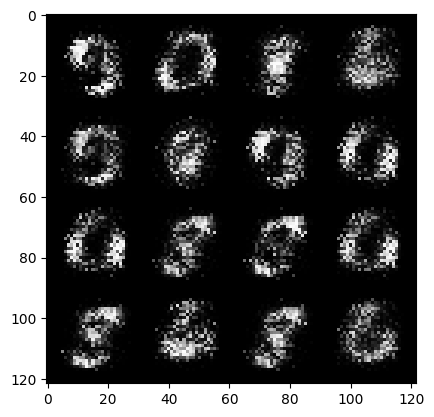

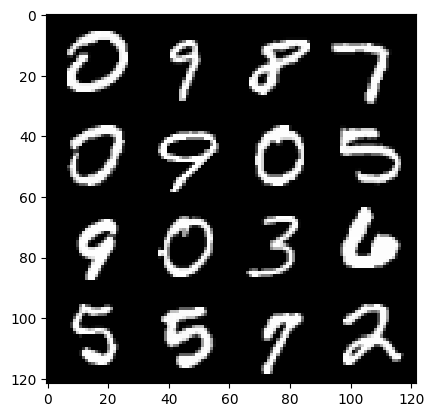

10: step 4800 / Gen loss: 6.268377966880795 / disc_loss: 0.015292942767652367


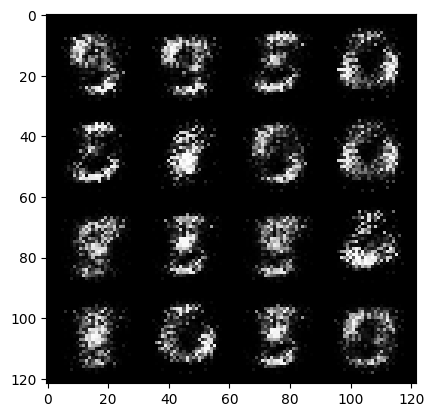

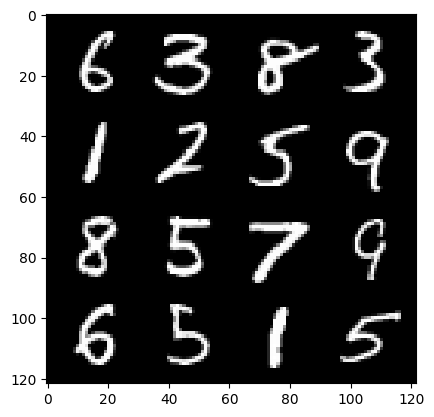

10: step 5100 / Gen loss: 6.547389012972513 / disc_loss: 0.013057582854914164


  0%|          | 0/469 [00:00<?, ?it/s]

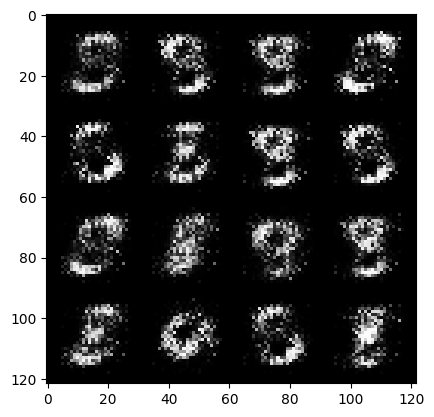

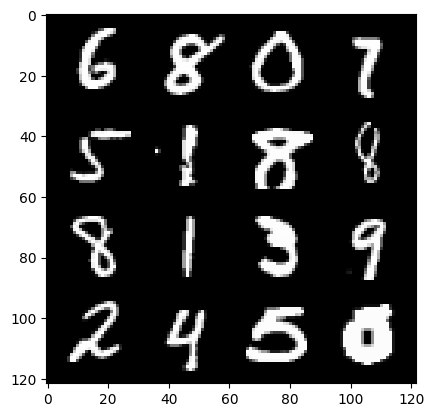

11: step 5400 / Gen loss: 6.615126709938051 / disc_loss: 0.011833248802771165


  0%|          | 0/469 [00:00<?, ?it/s]

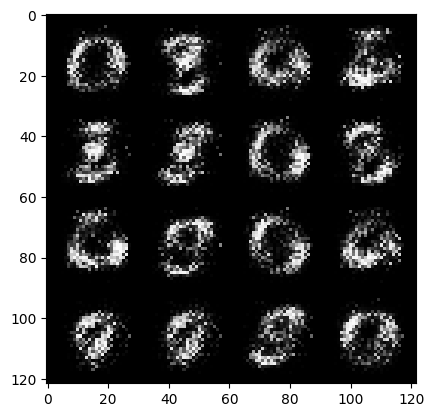

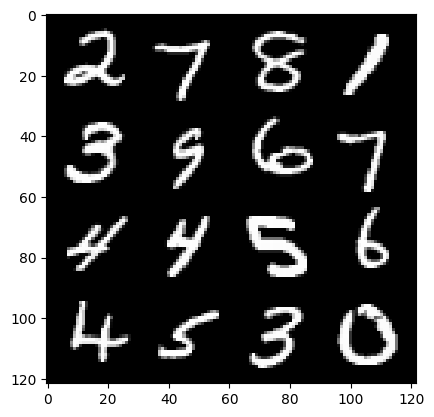

12: step 5700 / Gen loss: 6.5391778898239155 / disc_loss: 0.01136043204305072


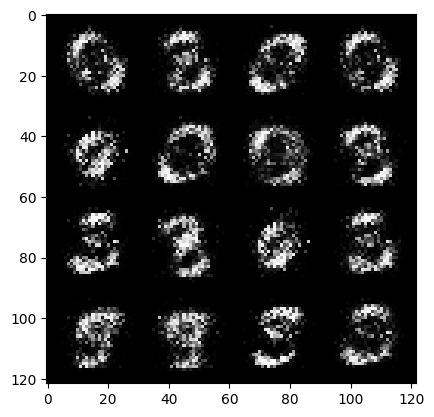

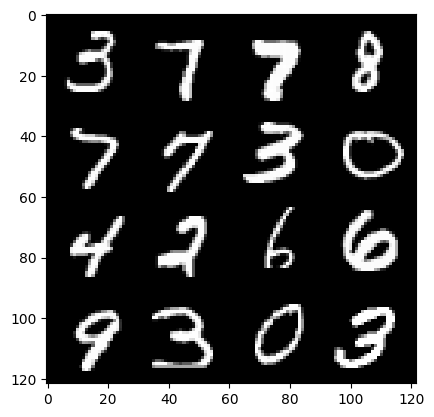

12: step 6000 / Gen loss: 6.632350665728251 / disc_loss: 0.012742729728731013


  0%|          | 0/469 [00:00<?, ?it/s]

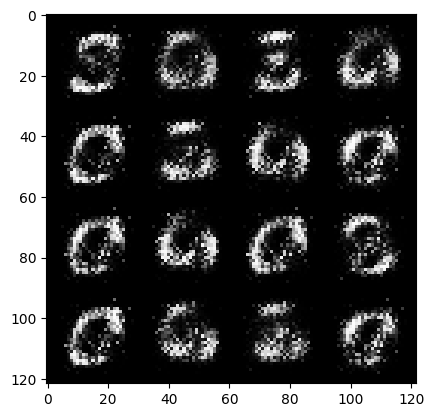

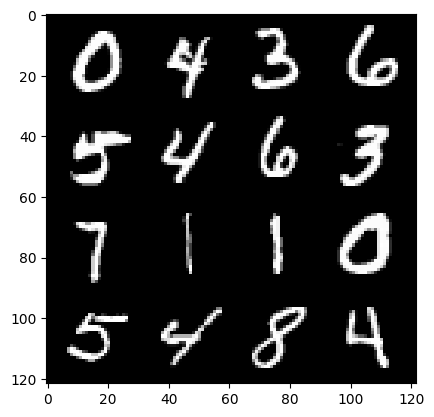

13: step 6300 / Gen loss: 6.480312794049575 / disc_loss: 0.01409260384738446


  0%|          | 0/469 [00:00<?, ?it/s]

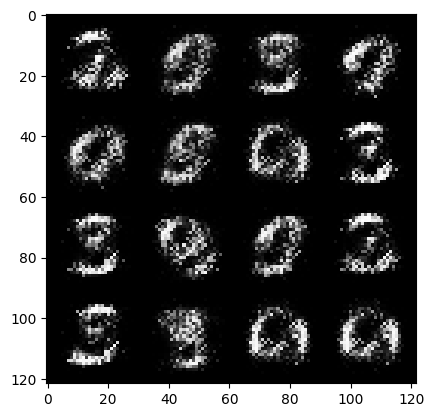

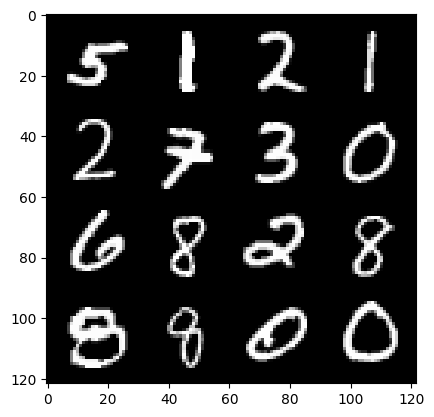

14: step 6600 / Gen loss: 6.7606861861546825 / disc_loss: 0.014576507899910211


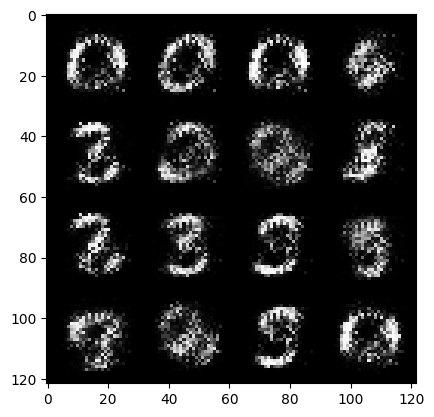

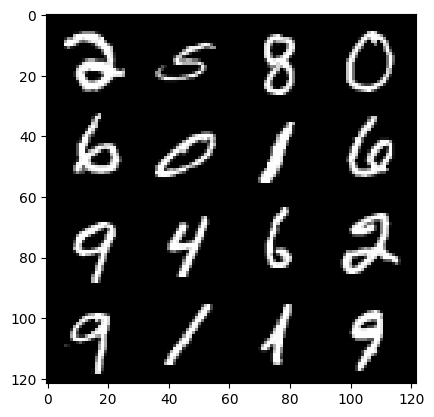

14: step 6900 / Gen loss: 6.936133017539981 / disc_loss: 0.013595184415268392


  0%|          | 0/469 [00:00<?, ?it/s]

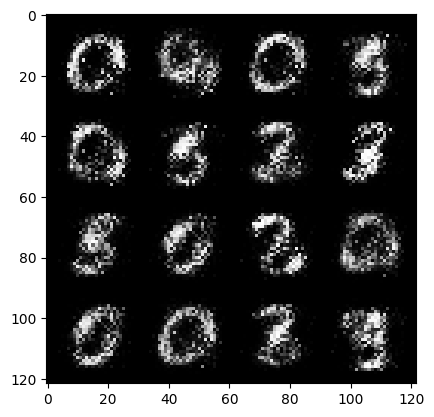

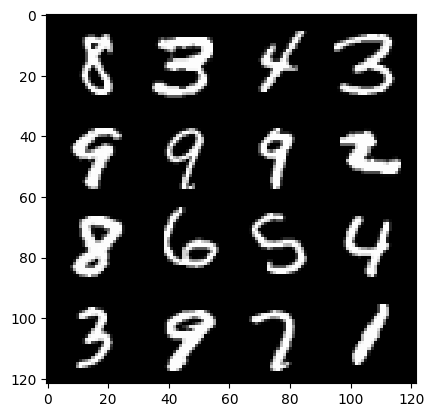

15: step 7200 / Gen loss: 7.101926964124047 / disc_loss: 0.012805460445427644


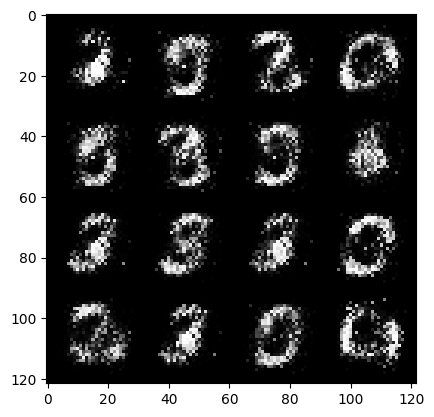

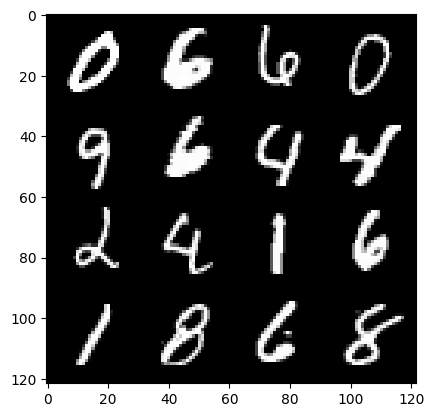

15: step 7500 / Gen loss: 7.016593589782715 / disc_loss: 0.01186271171784028


  0%|          | 0/469 [00:00<?, ?it/s]

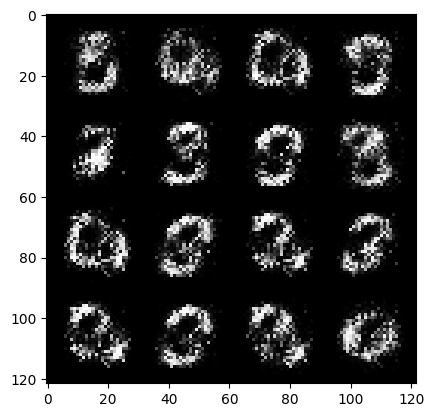

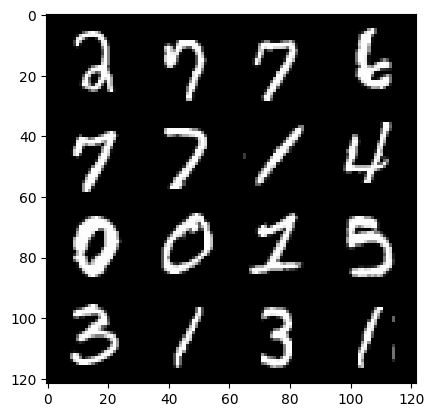

16: step 7800 / Gen loss: 6.838046449025467 / disc_loss: 0.011282585304385674


  0%|          | 0/469 [00:00<?, ?it/s]

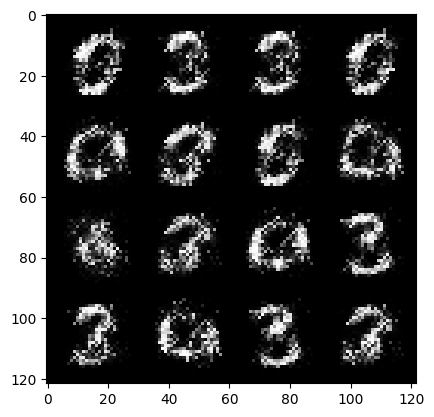

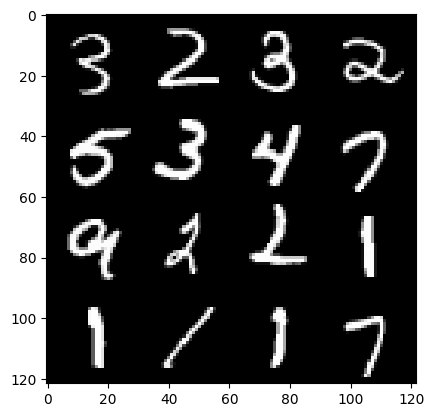

17: step 8100 / Gen loss: 7.147462375958761 / disc_loss: 0.010570787289955955


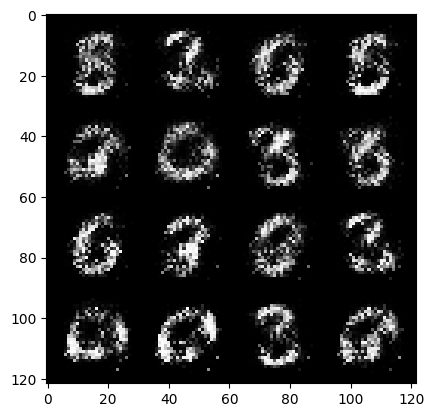

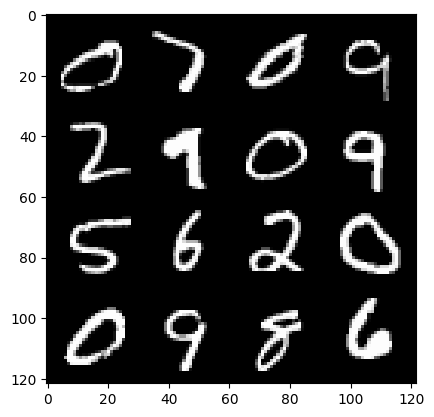

17: step 8400 / Gen loss: 7.757357862790431 / disc_loss: 0.009980118216481067


  0%|          | 0/469 [00:00<?, ?it/s]

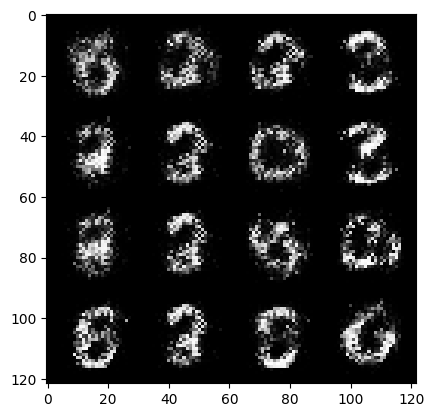

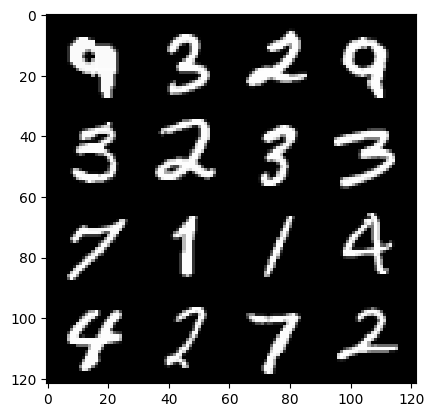

18: step 8700 / Gen loss: 7.770892224311832 / disc_loss: 0.008582391704743108


  0%|          | 0/469 [00:00<?, ?it/s]

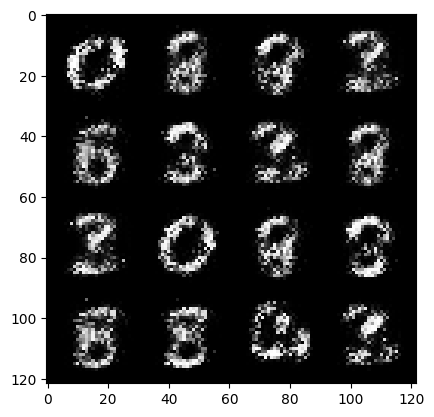

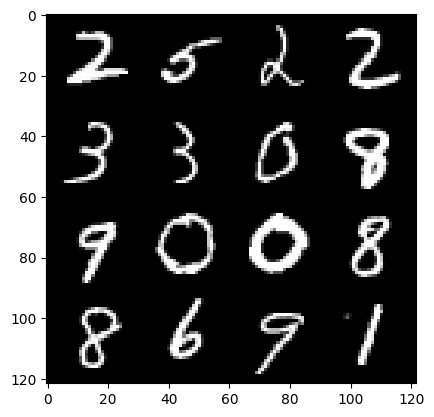

19: step 9000 / Gen loss: 7.099205304781595 / disc_loss: 0.01015835861985882


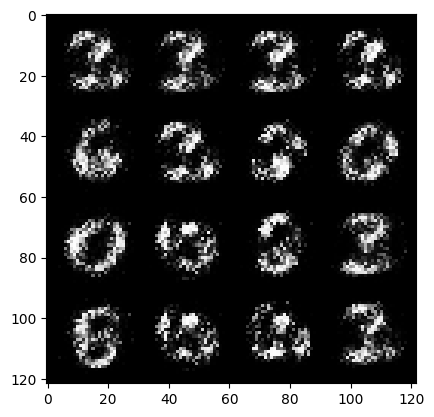

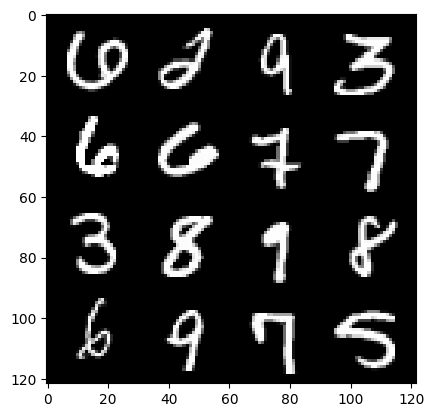

19: step 9300 / Gen loss: 7.2088170973459835 / disc_loss: 0.009234951505592717


  0%|          | 0/469 [00:00<?, ?it/s]

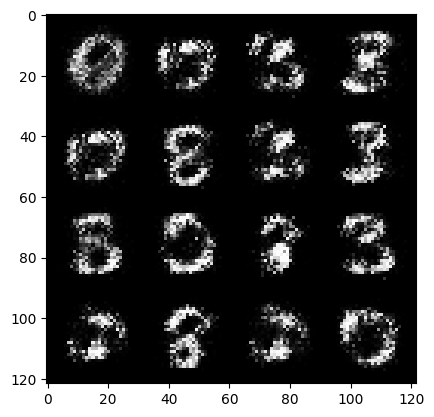

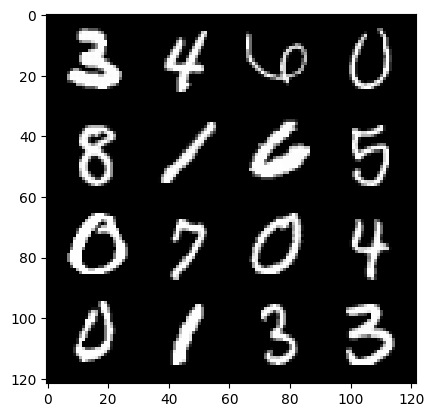

20: step 9600 / Gen loss: 7.151523583730066 / disc_loss: 0.009563557193226492


  0%|          | 0/469 [00:00<?, ?it/s]

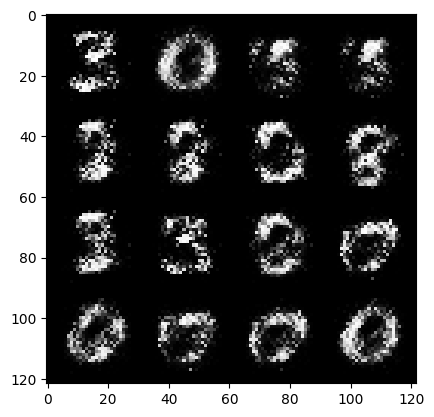

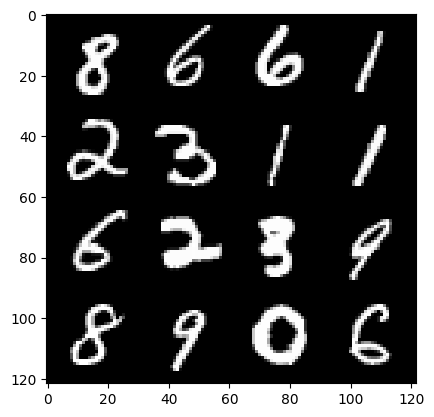

21: step 9900 / Gen loss: 7.646172122955321 / disc_loss: 0.010314237725688147


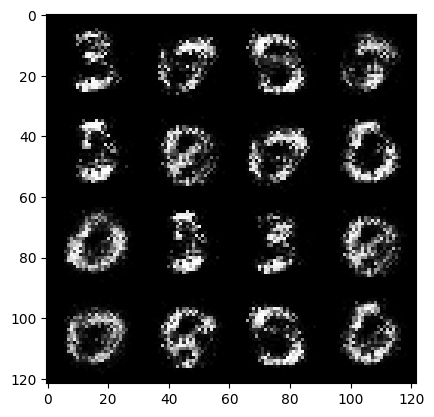

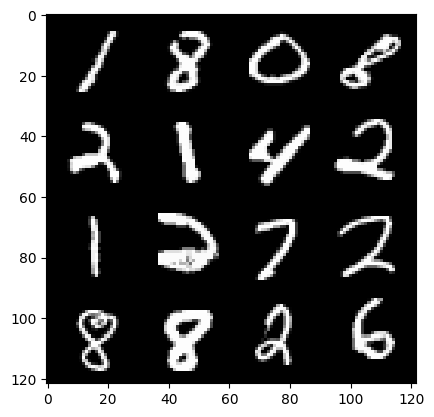

21: step 10200 / Gen loss: 7.681248278617858 / disc_loss: 0.011522143268181625


  0%|          | 0/469 [00:00<?, ?it/s]

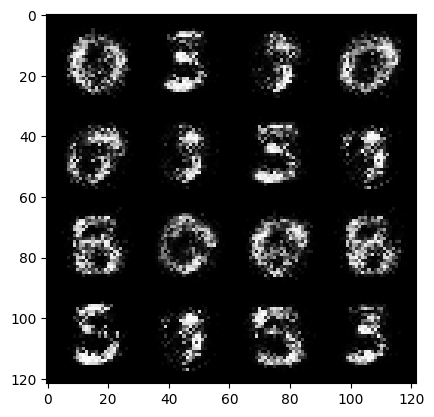

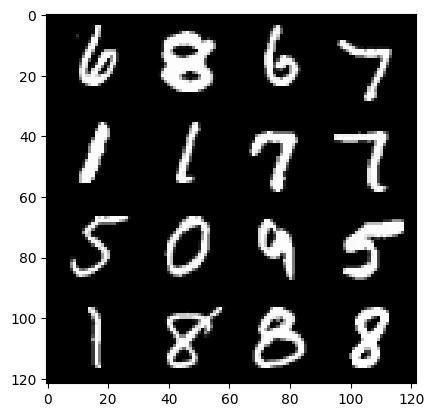

22: step 10500 / Gen loss: 7.4819814348220826 / disc_loss: 0.010434215630715095


  0%|          | 0/469 [00:00<?, ?it/s]

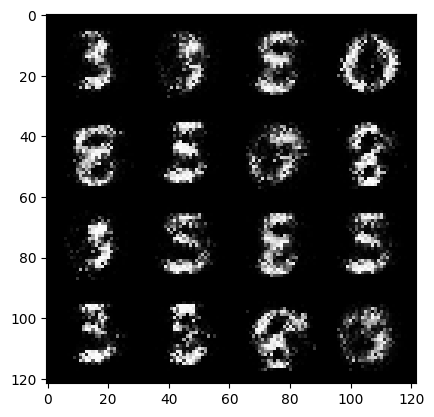

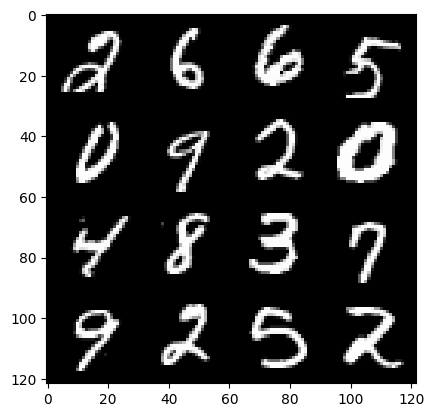

23: step 10800 / Gen loss: 7.478857083320616 / disc_loss: 0.01123691642967363


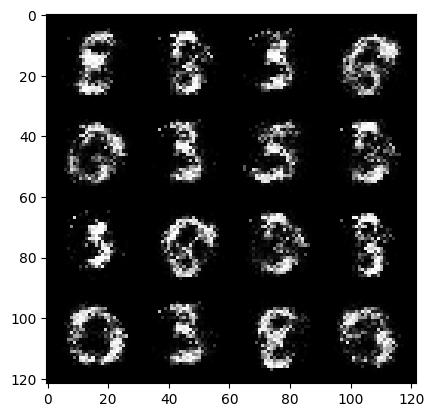

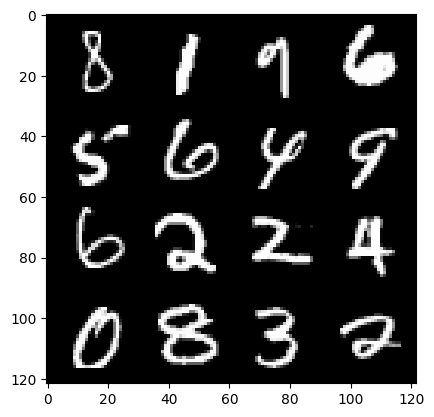

23: step 11100 / Gen loss: 7.5603126319249485 / disc_loss: 0.011072092234777913


  0%|          | 0/469 [00:00<?, ?it/s]

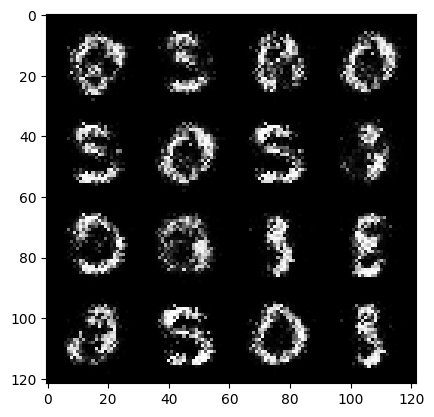

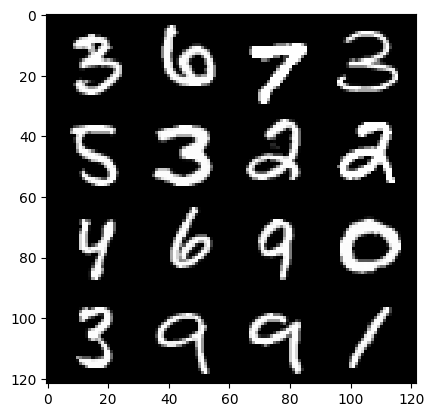

24: step 11400 / Gen loss: 7.301910319328306 / disc_loss: 0.012557428628982358


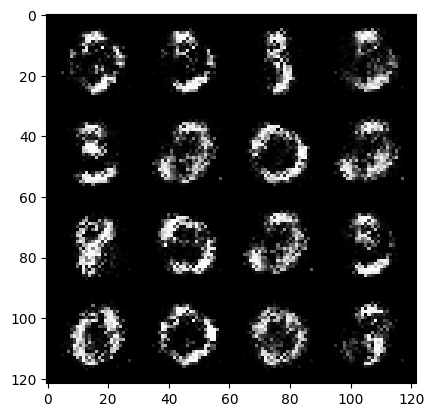

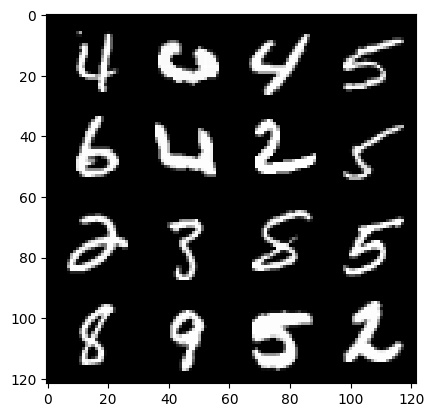

24: step 11700 / Gen loss: 7.902936450640361 / disc_loss: 0.012014093557372697


  0%|          | 0/469 [00:00<?, ?it/s]

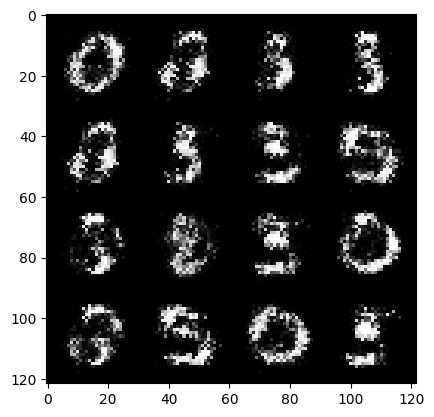

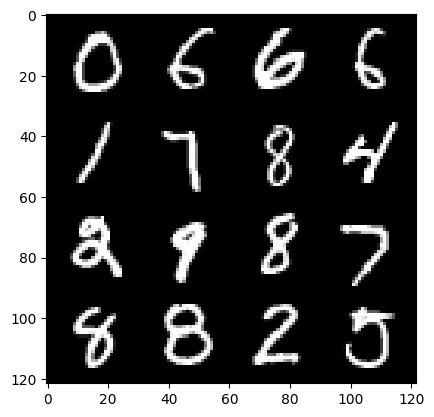

25: step 12000 / Gen loss: 7.22429442405701 / disc_loss: 0.01185491912028131


  0%|          | 0/469 [00:00<?, ?it/s]

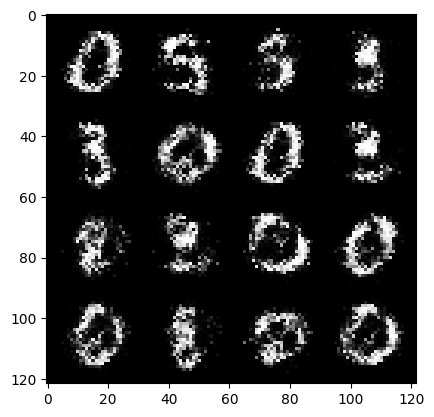

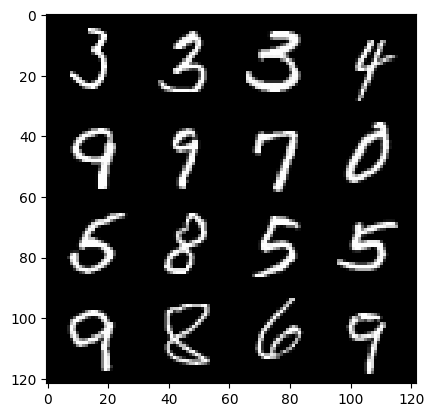

26: step 12300 / Gen loss: 6.988640933036806 / disc_loss: 0.00964486314721094


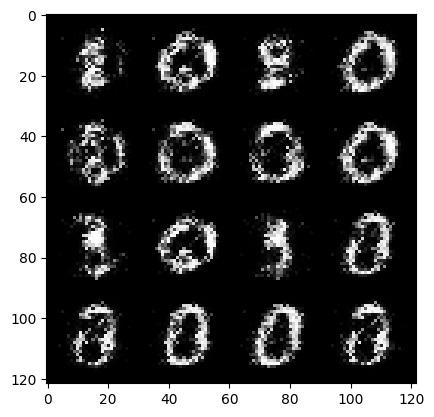

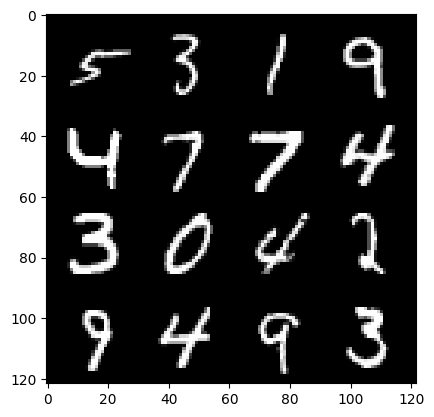

26: step 12600 / Gen loss: 7.825228182474773 / disc_loss: 0.009167519401138033


  0%|          | 0/469 [00:00<?, ?it/s]

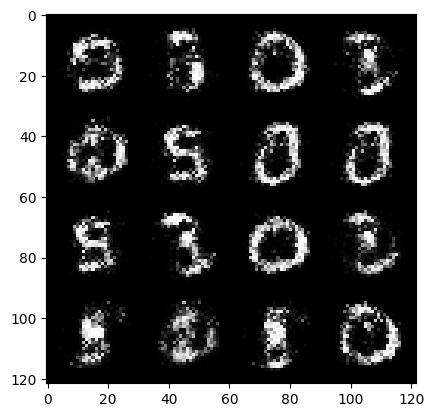

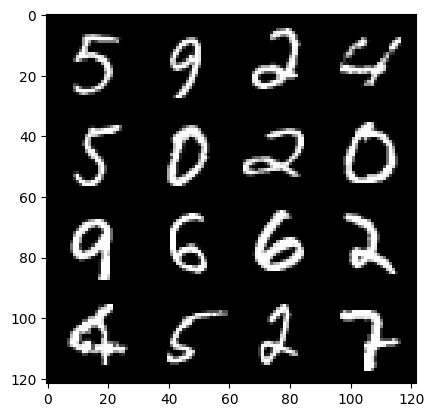

27: step 12900 / Gen loss: 7.886647917429604 / disc_loss: 0.012104385315906258


  0%|          | 0/469 [00:00<?, ?it/s]

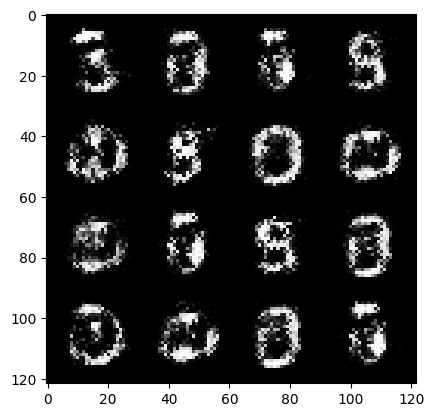

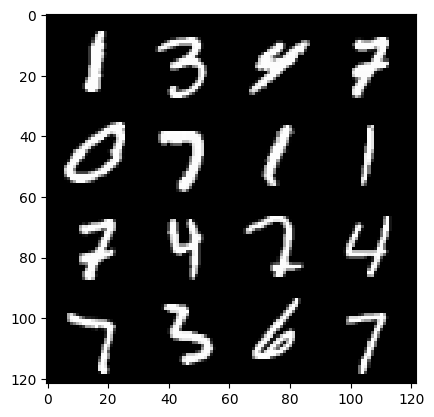

28: step 13200 / Gen loss: 7.100654468536375 / disc_loss: 0.012387023049717137


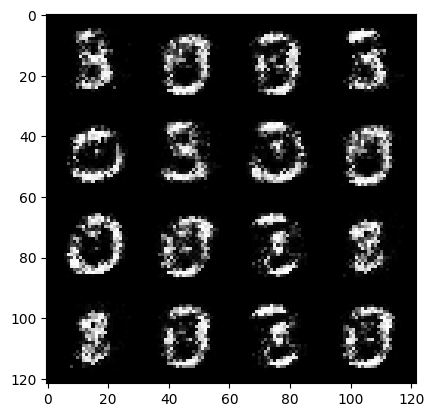

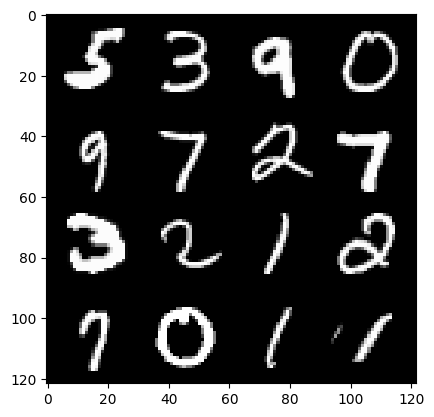

28: step 13500 / Gen loss: 7.008564421335854 / disc_loss: 0.011330795397904388


  0%|          | 0/469 [00:00<?, ?it/s]

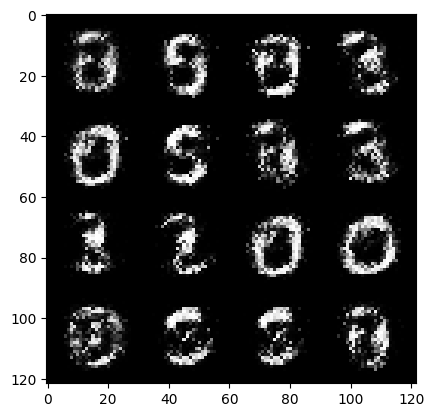

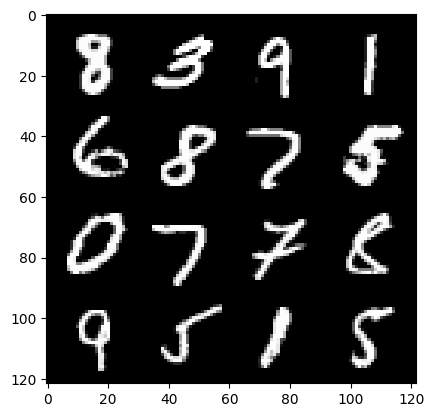

29: step 13800 / Gen loss: 6.909793275197352 / disc_loss: 0.012510264044006668


  0%|          | 0/469 [00:00<?, ?it/s]

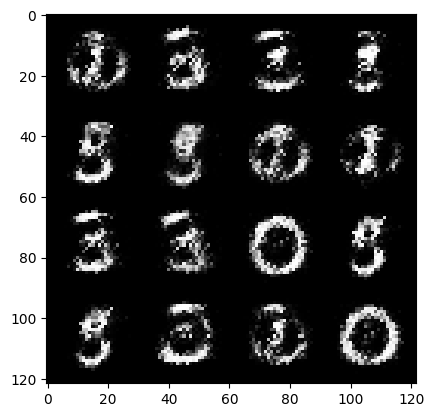

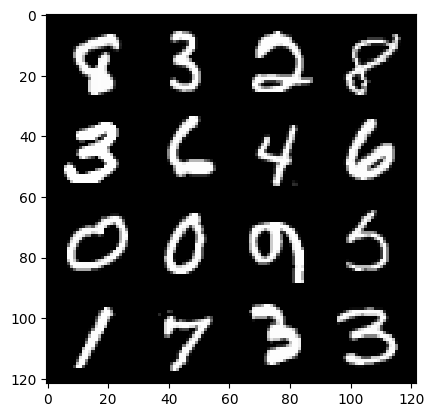

30: step 14100 / Gen loss: 6.97478347142537 / disc_loss: 0.014119860973830028


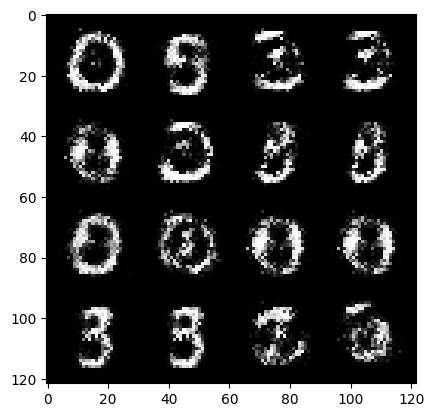

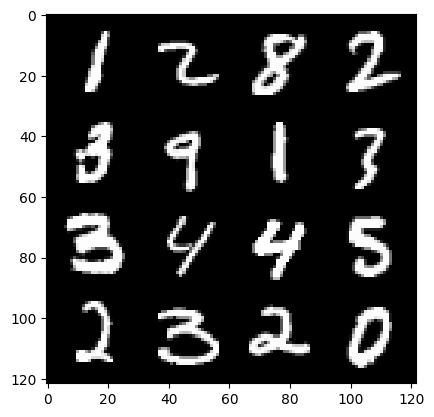

30: step 14400 / Gen loss: 6.4551135015487615 / disc_loss: 0.016785789459633334


  0%|          | 0/469 [00:00<?, ?it/s]

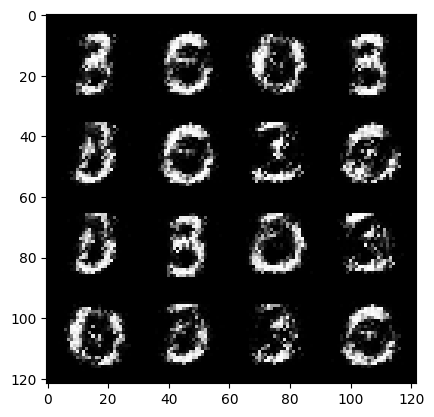

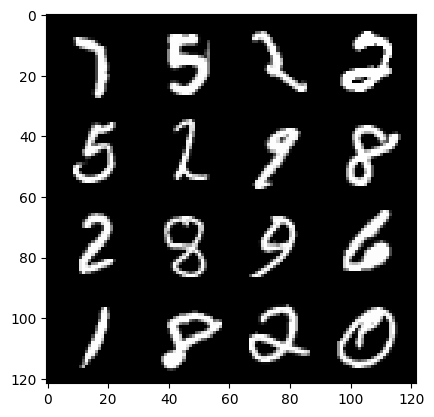

31: step 14700 / Gen loss: 6.552922375996911 / disc_loss: 0.0157135125854984


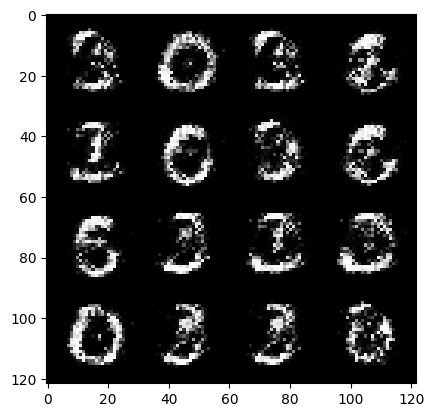

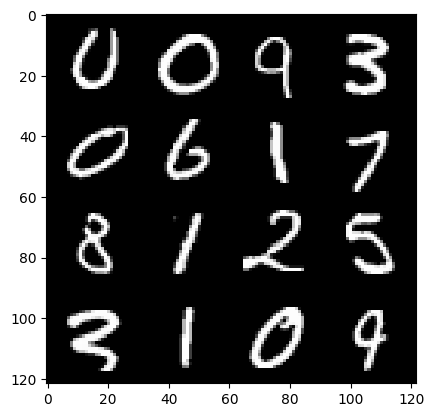

31: step 15000 / Gen loss: 6.418933321634931 / disc_loss: 0.01405090605063985


  0%|          | 0/469 [00:00<?, ?it/s]

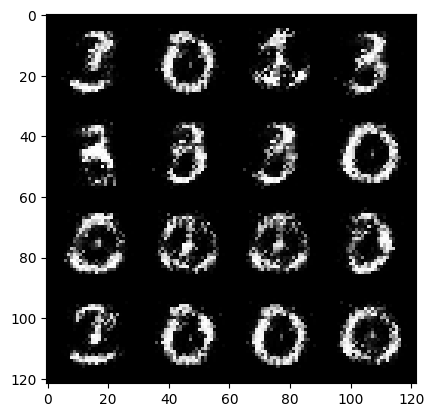

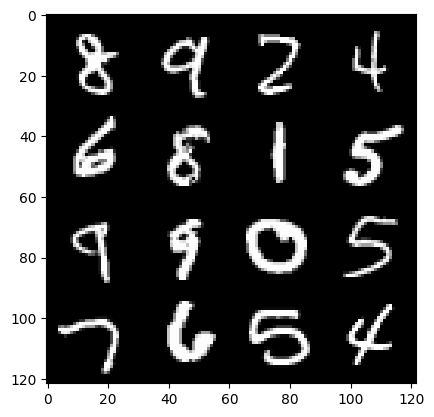

32: step 15300 / Gen loss: 6.73433040142059 / disc_loss: 0.014103448268336545


  0%|          | 0/469 [00:00<?, ?it/s]

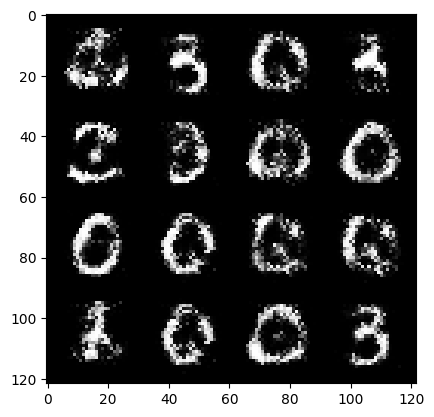

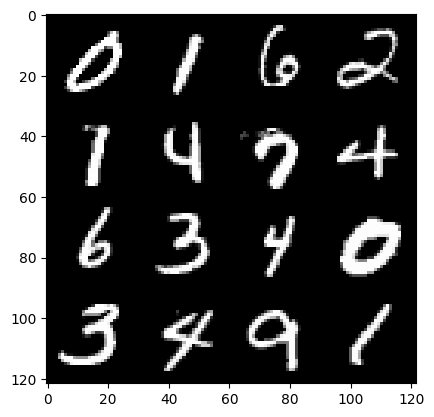

33: step 15600 / Gen loss: 6.725126268068953 / disc_loss: 0.013992918711155657


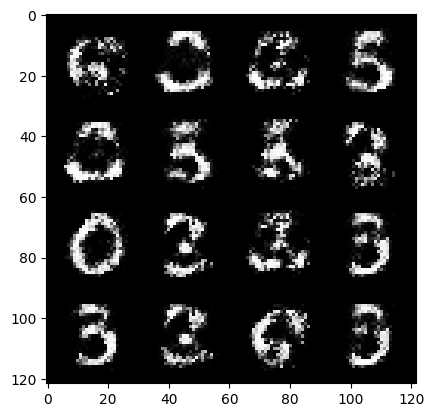

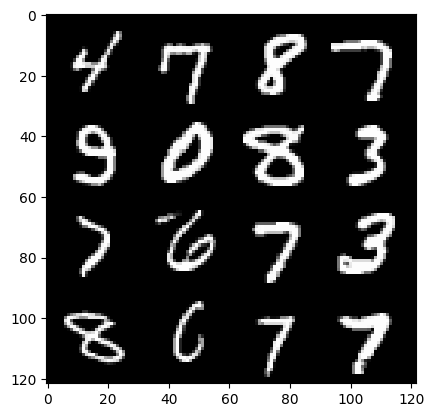

33: step 15900 / Gen loss: 6.6311530542373704 / disc_loss: 0.019216992134849228


  0%|          | 0/469 [00:00<?, ?it/s]

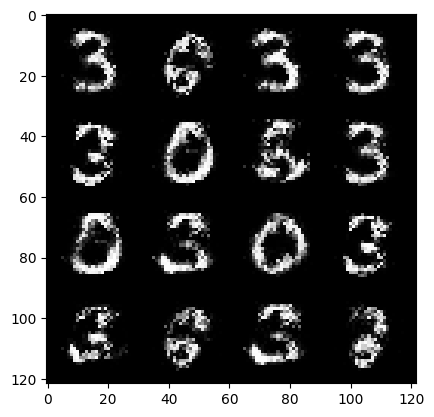

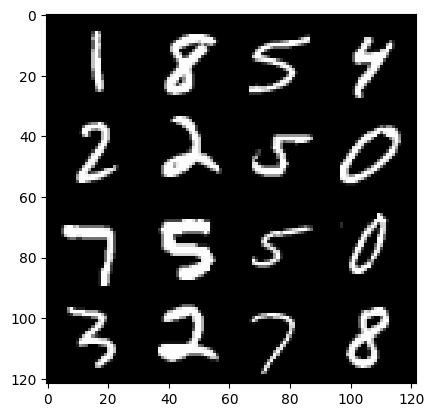

34: step 16200 / Gen loss: 6.488649328549699 / disc_loss: 0.0183165600282761


  0%|          | 0/469 [00:00<?, ?it/s]

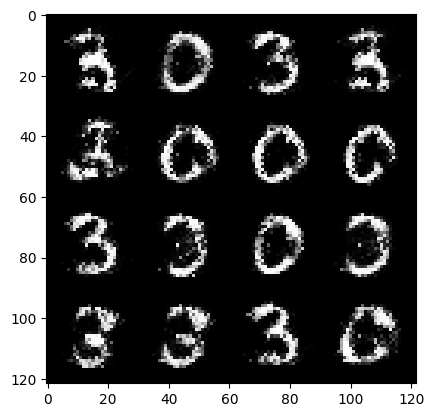

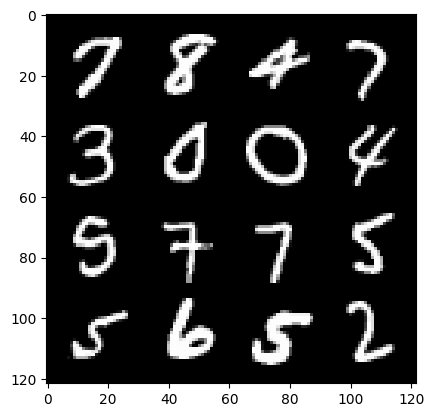

35: step 16500 / Gen loss: 6.657307661374408 / disc_loss: 0.017352047734893867


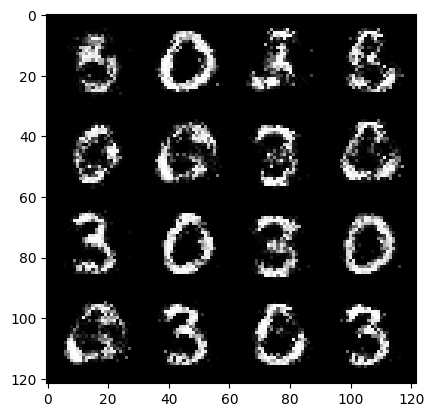

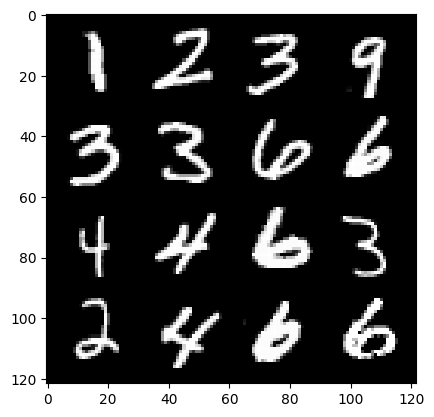

35: step 16800 / Gen loss: 7.060564587910974 / disc_loss: 0.015617688089453931


  0%|          | 0/469 [00:00<?, ?it/s]

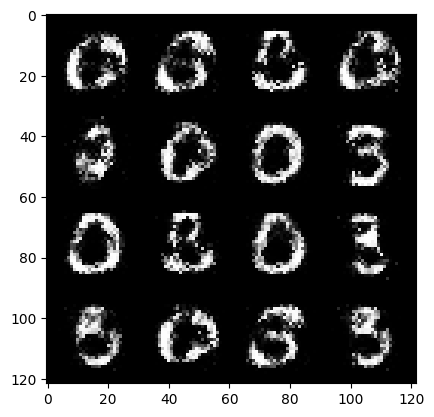

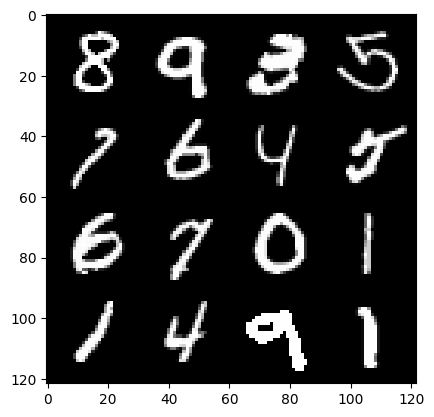

36: step 17100 / Gen loss: 6.978931536674504 / disc_loss: 0.017827246803014233


  0%|          | 0/469 [00:00<?, ?it/s]

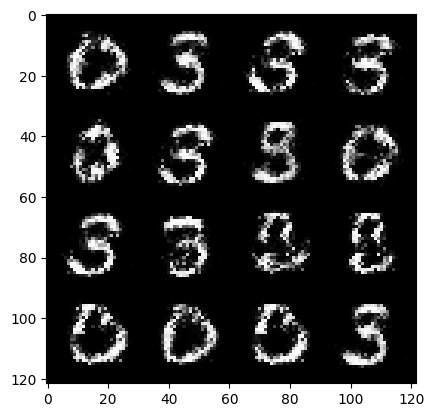

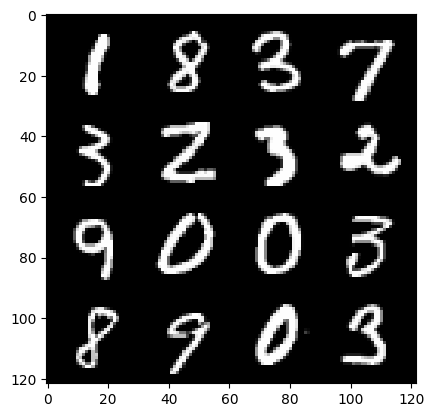

37: step 17400 / Gen loss: 6.653179318110148 / disc_loss: 0.022628181049755454


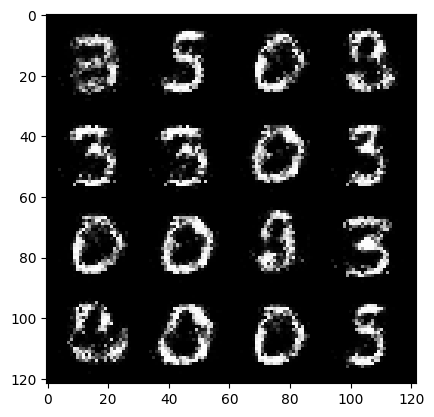

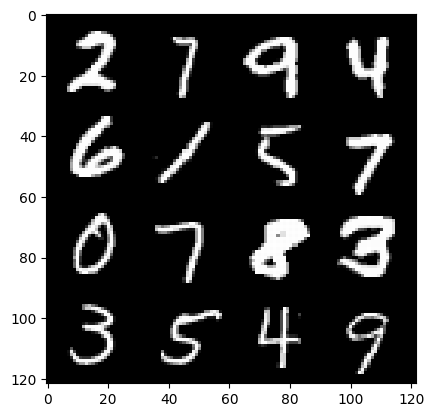

37: step 17700 / Gen loss: 6.580332425435386 / disc_loss: 0.02641489842130492


  0%|          | 0/469 [00:00<?, ?it/s]

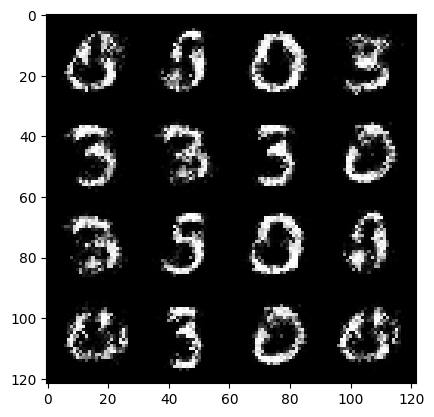

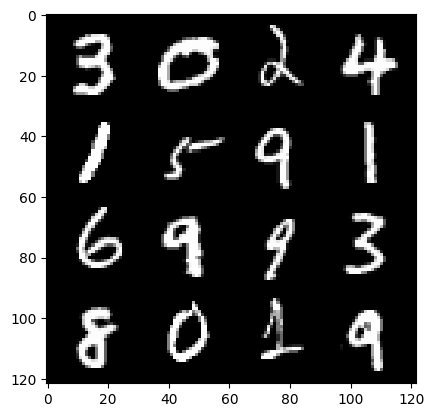

38: step 18000 / Gen loss: 6.973390858968102 / disc_loss: 0.03181194511863092


  0%|          | 0/469 [00:00<?, ?it/s]

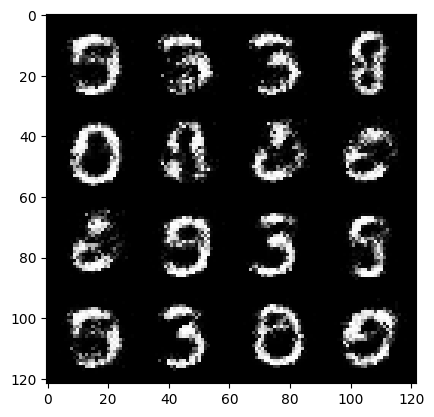

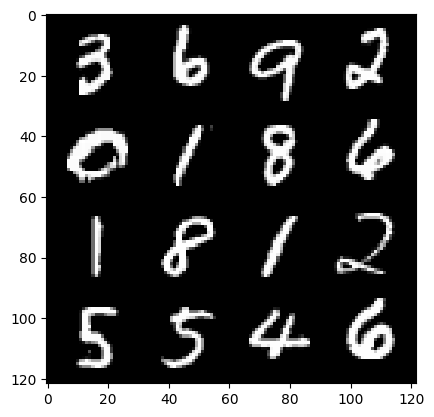

39: step 18300 / Gen loss: 6.372591915130615 / disc_loss: 0.03394710084112979


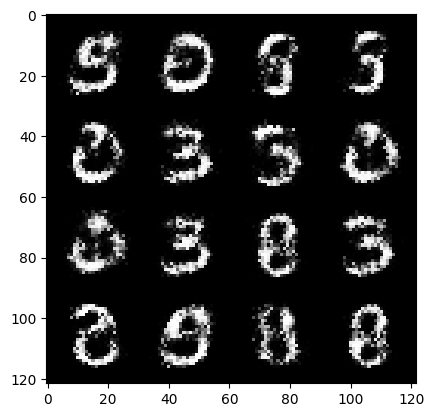

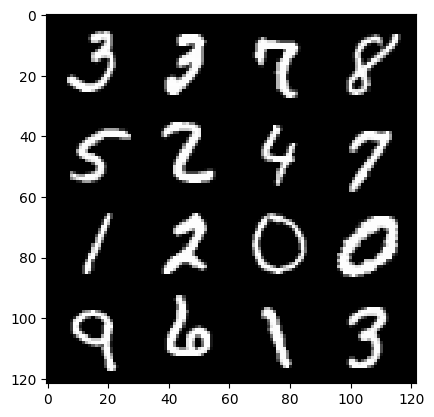

39: step 18600 / Gen loss: 6.0431309477488195 / disc_loss: 0.035175230645885035


  0%|          | 0/469 [00:00<?, ?it/s]

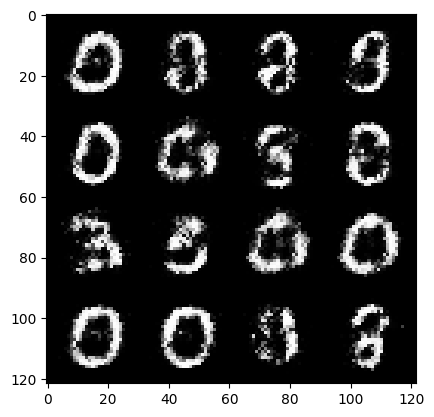

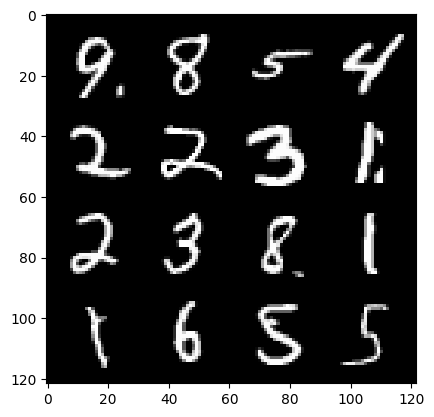

40: step 18900 / Gen loss: 6.328218968709309 / disc_loss: 0.034705529590137306


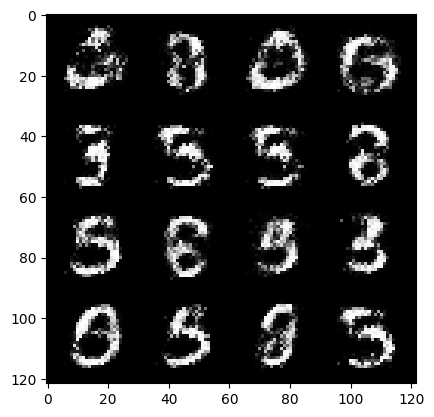

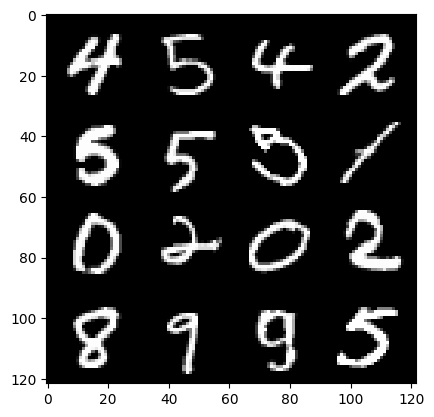

40: step 19200 / Gen loss: 5.975318266550701 / disc_loss: 0.03896407037662961


  0%|          | 0/469 [00:00<?, ?it/s]

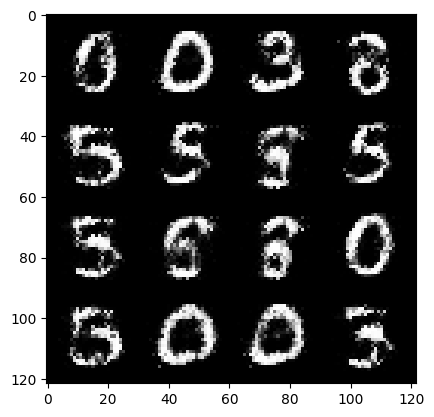

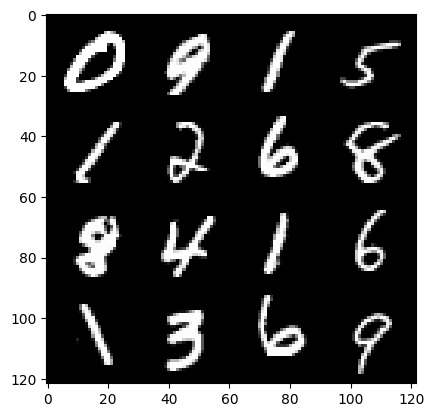

41: step 19500 / Gen loss: 5.718162965774534 / disc_loss: 0.03434122248087079


  0%|          | 0/469 [00:00<?, ?it/s]

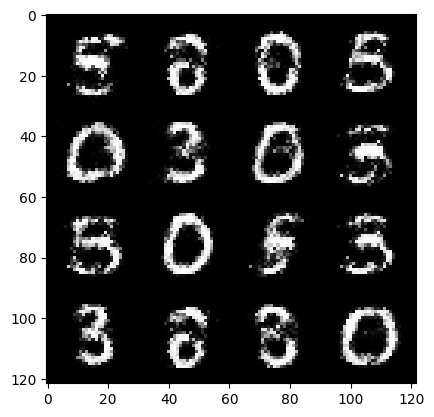

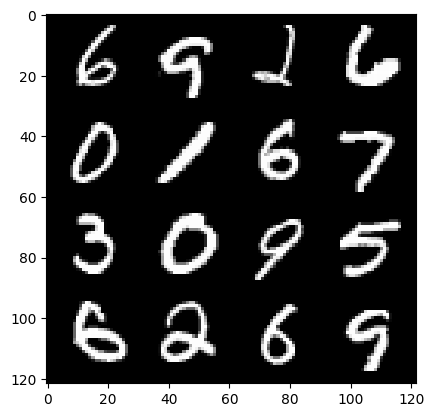

42: step 19800 / Gen loss: 5.832525414625804 / disc_loss: 0.03717729757850374


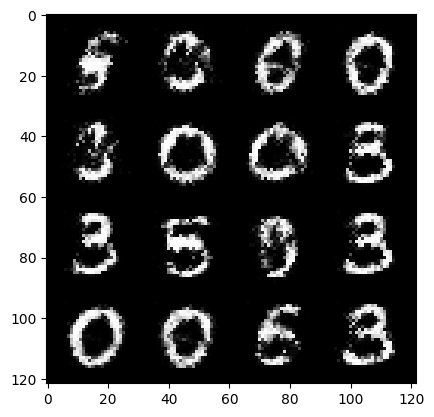

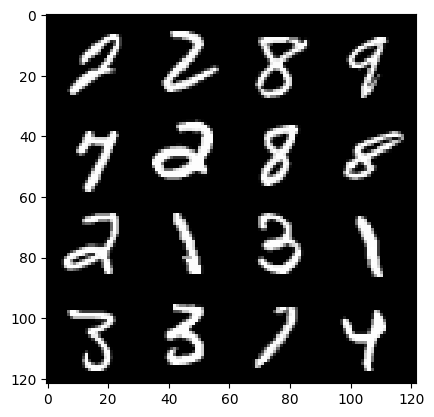

42: step 20100 / Gen loss: 5.538879763285318 / disc_loss: 0.041259902597715475


  0%|          | 0/469 [00:00<?, ?it/s]

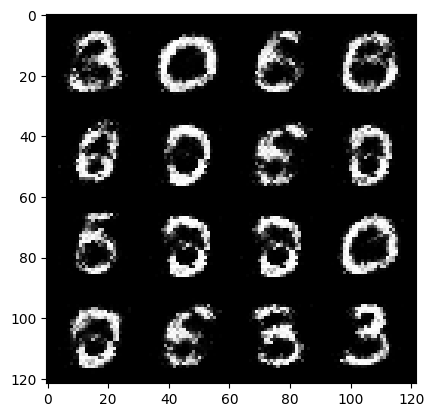

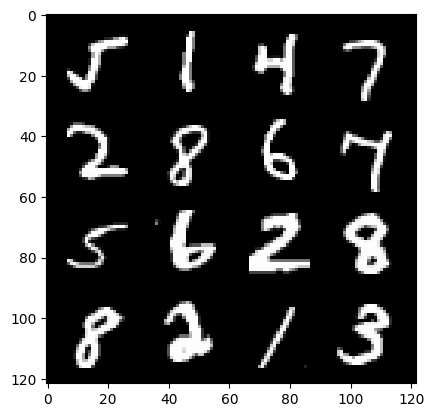

43: step 20400 / Gen loss: 5.418245832920077 / disc_loss: 0.0413336211380859


  0%|          | 0/469 [00:00<?, ?it/s]

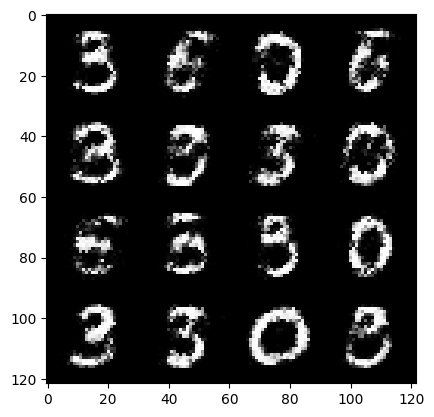

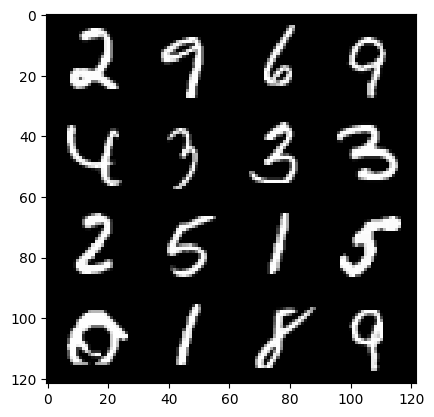

44: step 20700 / Gen loss: 5.721663184165952 / disc_loss: 0.04107837695938846


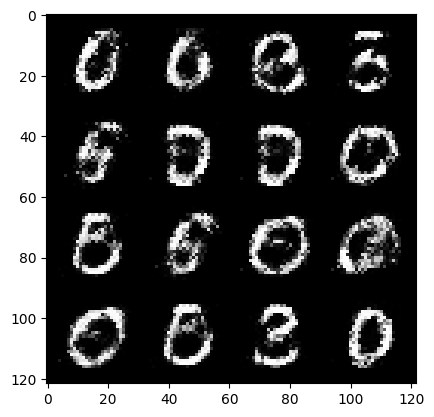

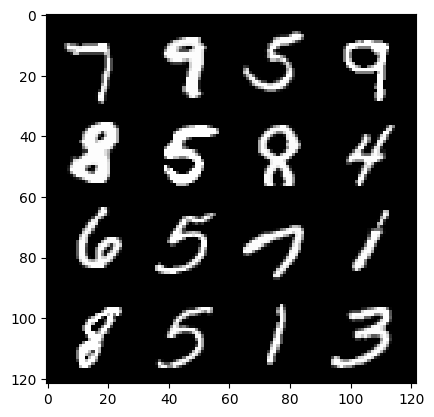

44: step 21000 / Gen loss: 5.655893414815266 / disc_loss: 0.04355610886278249


  0%|          | 0/469 [00:00<?, ?it/s]

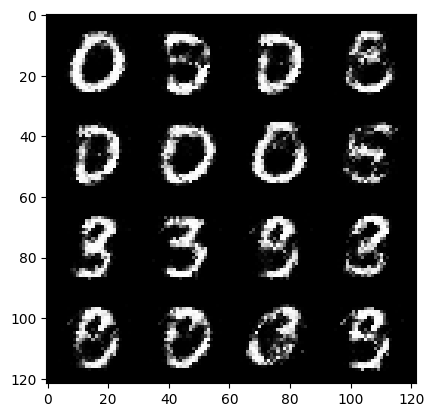

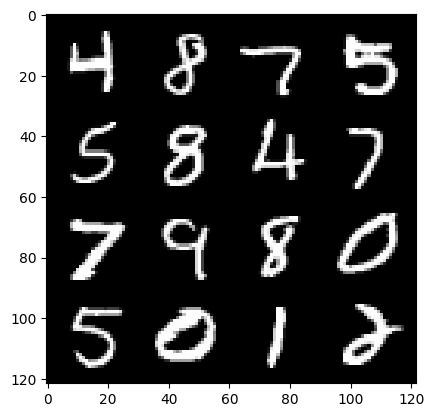

45: step 21300 / Gen loss: 5.507573316891991 / disc_loss: 0.04851899797717725


  0%|          | 0/469 [00:00<?, ?it/s]

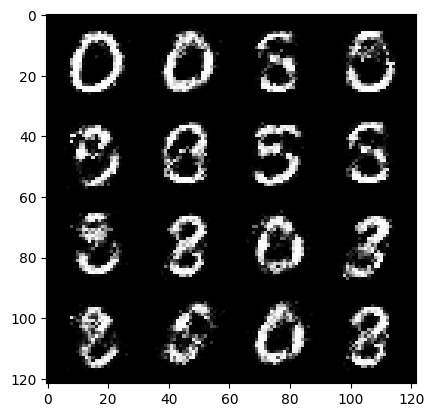

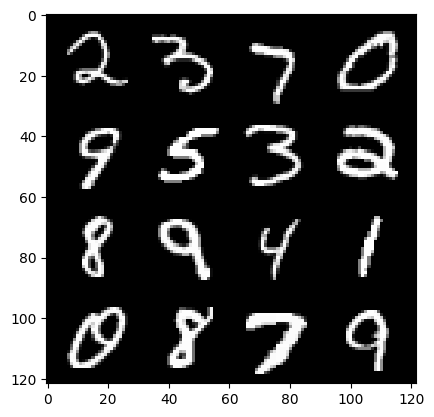

46: step 21600 / Gen loss: 5.347386406262715 / disc_loss: 0.055714449087778666


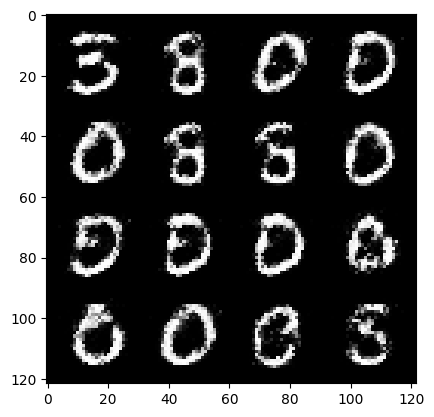

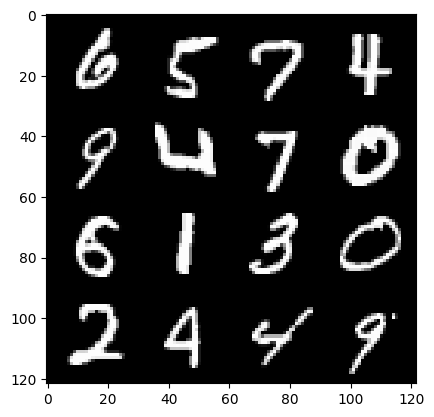

46: step 21900 / Gen loss: 5.156580858230592 / disc_loss: 0.052947028490404294


  0%|          | 0/469 [00:00<?, ?it/s]

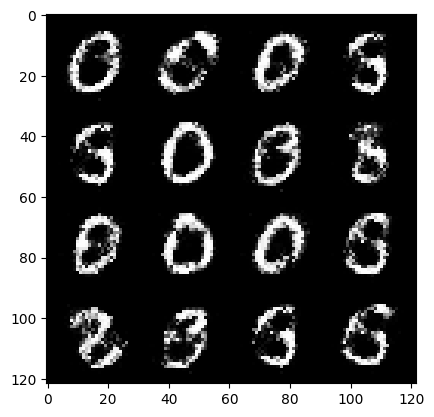

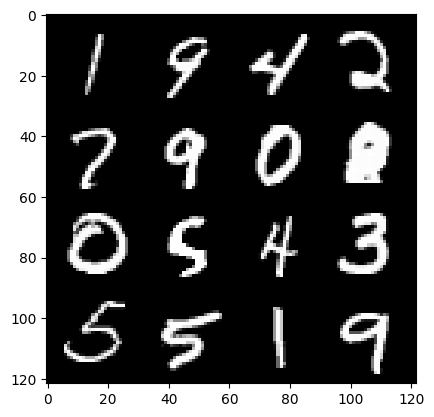

47: step 22200 / Gen loss: 5.265147910118101 / disc_loss: 0.048475945082803576


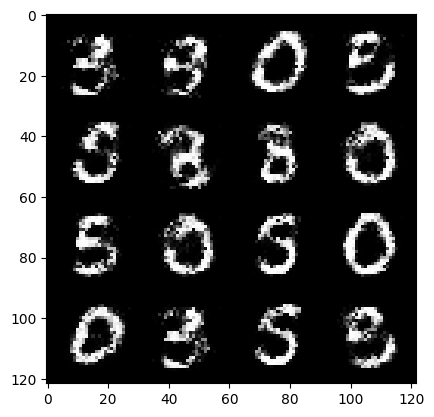

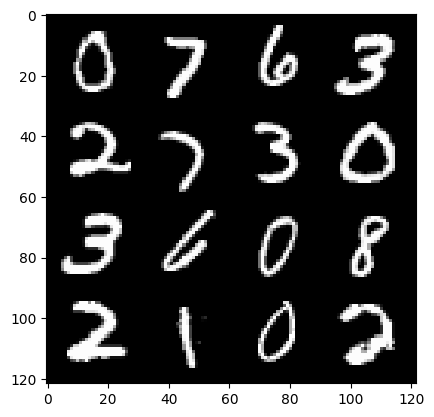

47: step 22500 / Gen loss: 5.416916626294456 / disc_loss: 0.0523261000371228


  0%|          | 0/469 [00:00<?, ?it/s]

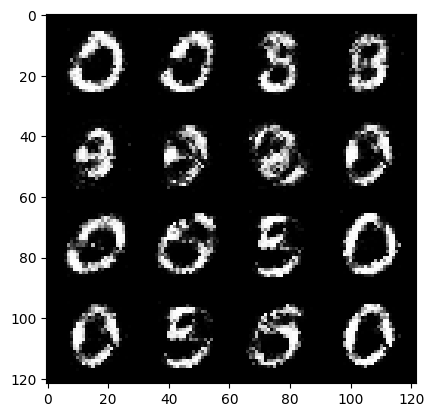

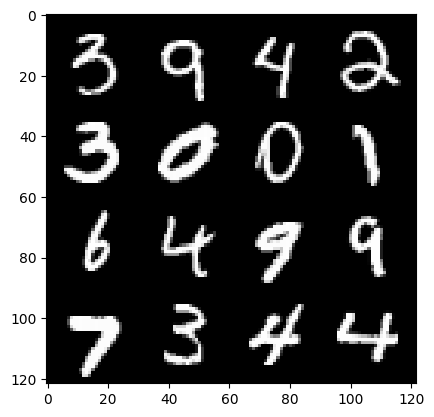

48: step 22800 / Gen loss: 5.228892202377319 / disc_loss: 0.06236352672800424


  0%|          | 0/469 [00:00<?, ?it/s]

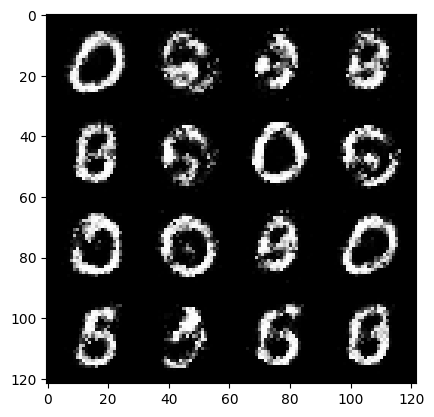

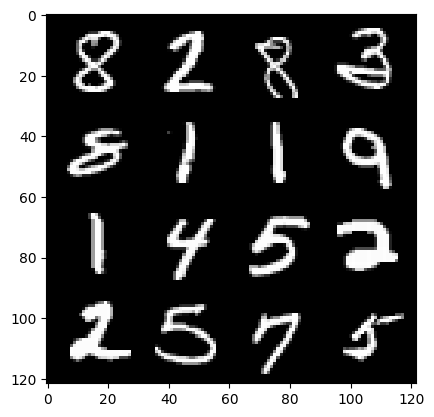

49: step 23100 / Gen loss: 4.981123991012568 / disc_loss: 0.06175465289503336


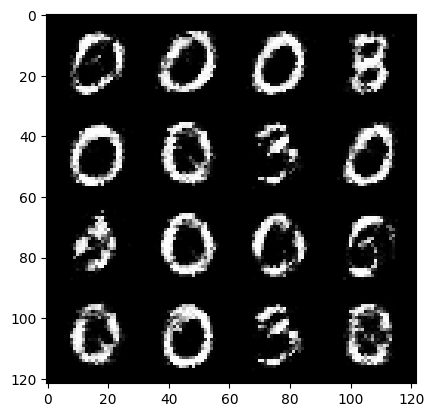

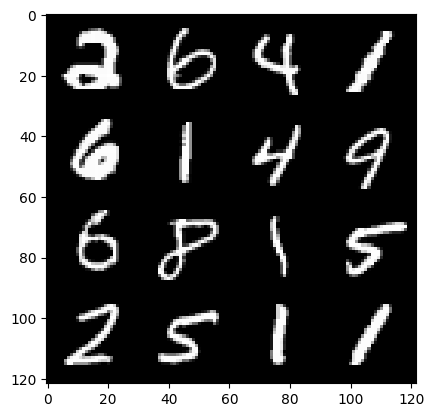

49: step 23400 / Gen loss: 4.762324453989666 / disc_loss: 0.07363632181038461


  0%|          | 0/469 [00:00<?, ?it/s]

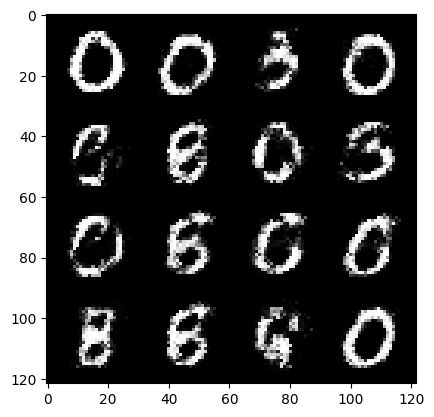

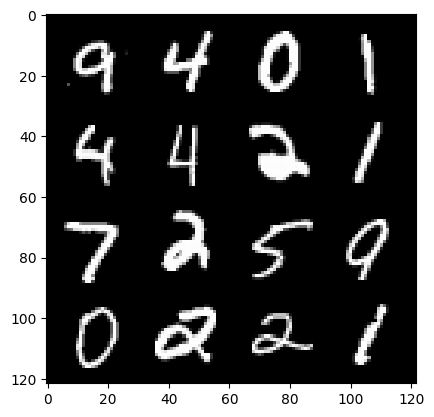

50: step 23700 / Gen loss: 5.0675932987530965 / disc_loss: 0.06742535434663295


  0%|          | 0/469 [00:00<?, ?it/s]

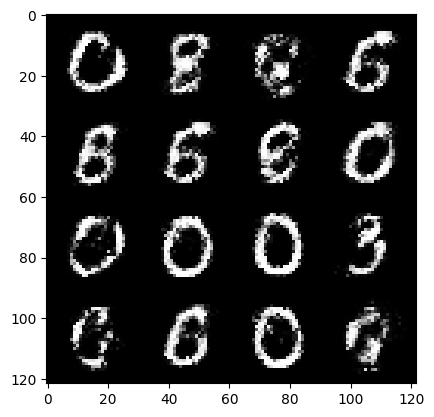

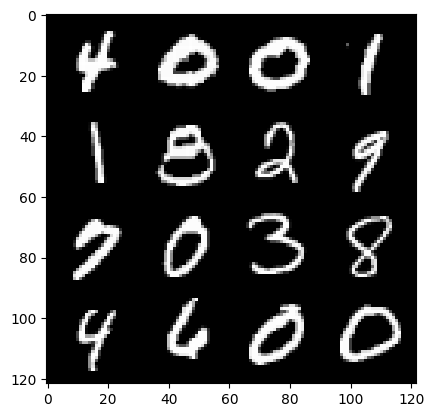

51: step 24000 / Gen loss: 5.171234624385834 / disc_loss: 0.06923339694117506


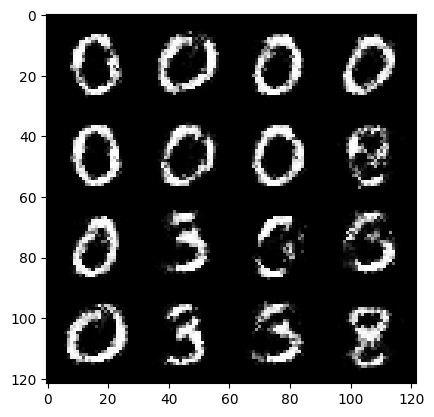

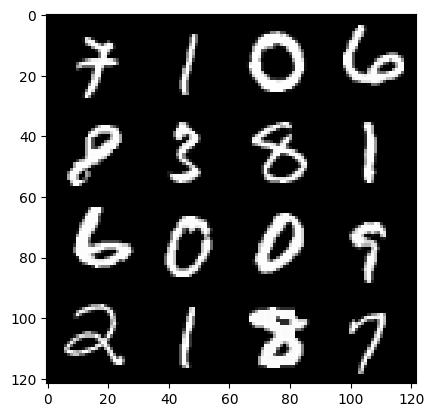

51: step 24300 / Gen loss: 5.181371134122215 / disc_loss: 0.07122746466348573


  0%|          | 0/469 [00:00<?, ?it/s]

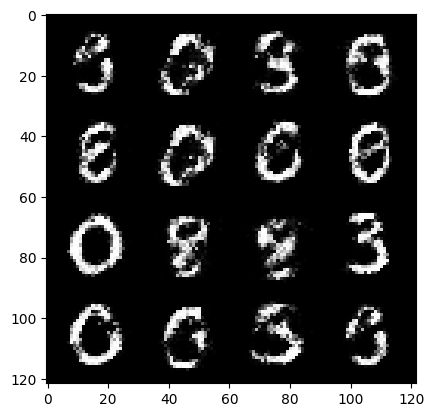

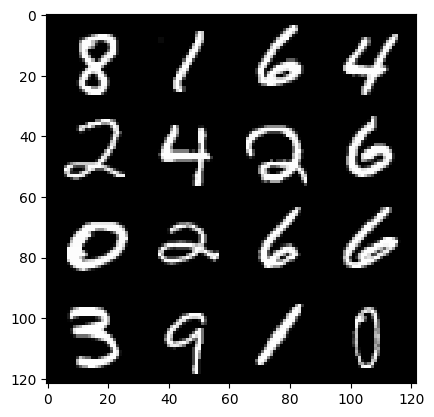

52: step 24600 / Gen loss: 4.923765554428105 / disc_loss: 0.08853625752031806


  0%|          | 0/469 [00:00<?, ?it/s]

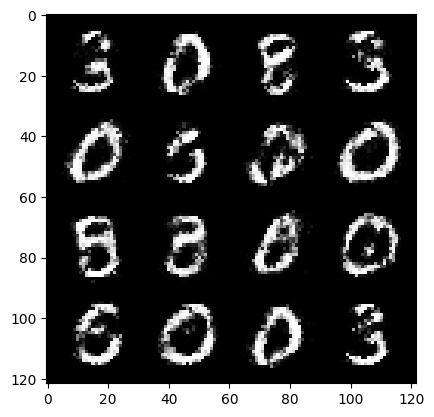

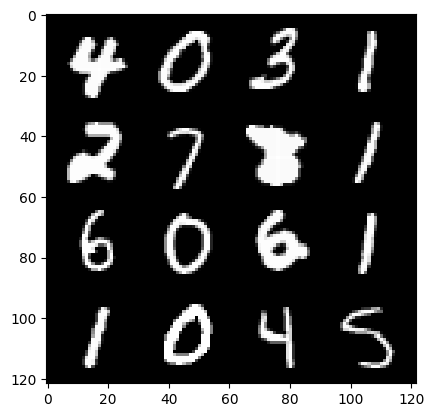

53: step 24900 / Gen loss: 4.961543195247648 / disc_loss: 0.09404998491207758


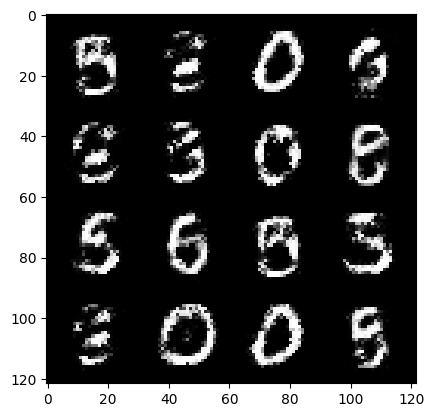

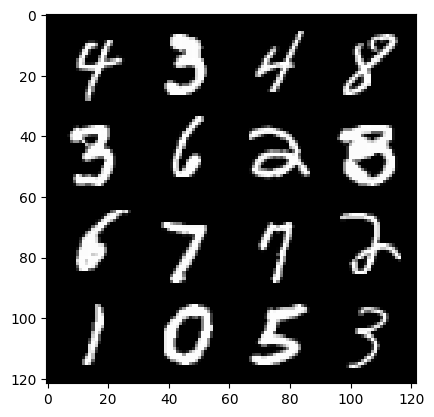

53: step 25200 / Gen loss: 4.74897397438685 / disc_loss: 0.08561143679544315


  0%|          | 0/469 [00:00<?, ?it/s]

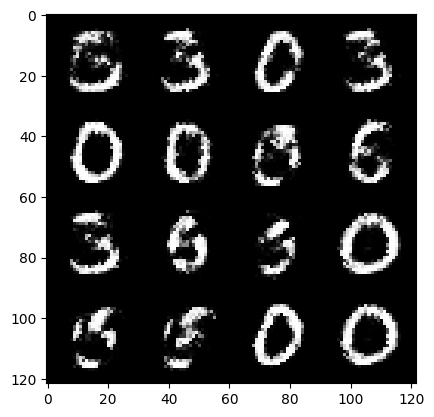

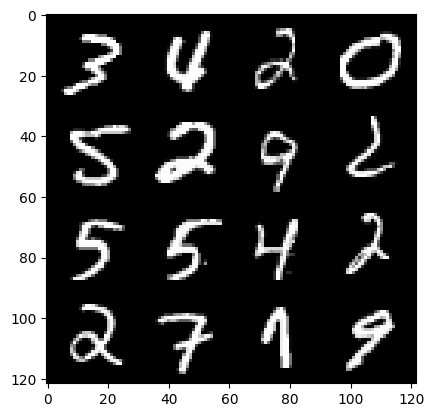

54: step 25500 / Gen loss: 4.720760014057159 / disc_loss: 0.07833100660393635


  0%|          | 0/469 [00:00<?, ?it/s]

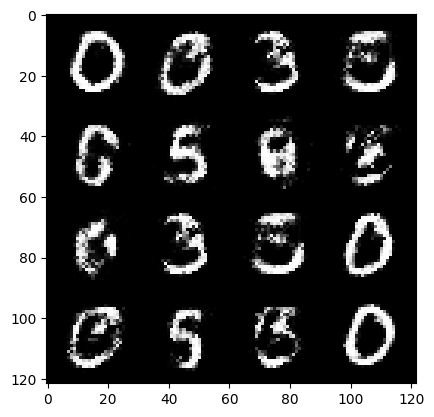

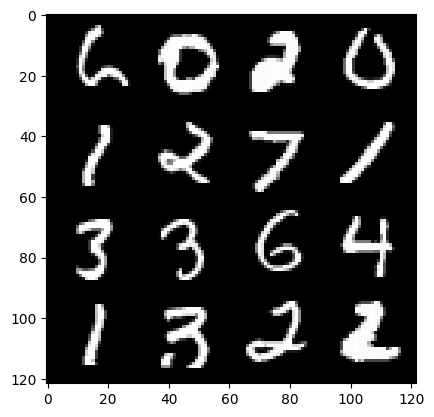

55: step 25800 / Gen loss: 4.810564578374222 / disc_loss: 0.08066710637882353


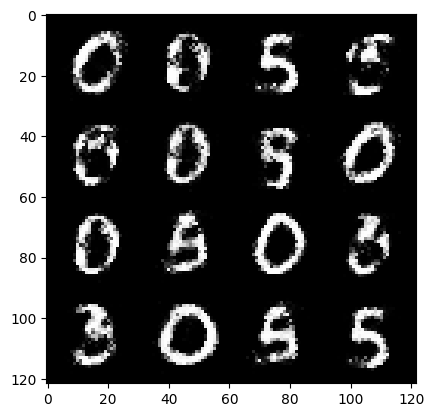

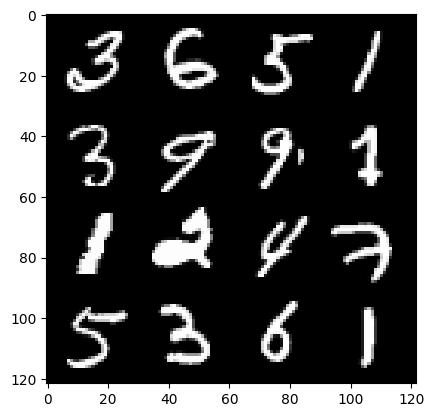

55: step 26100 / Gen loss: 4.713839848041532 / disc_loss: 0.08340426582843058


  0%|          | 0/469 [00:00<?, ?it/s]

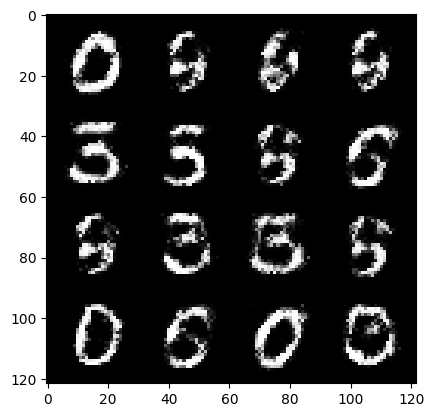

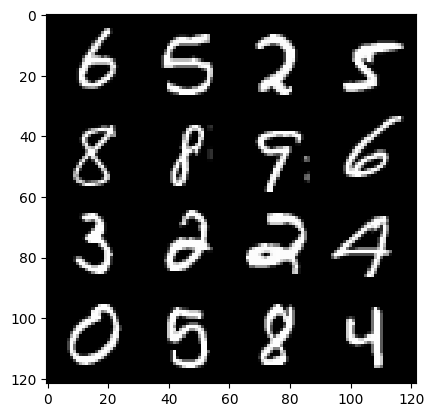

56: step 26400 / Gen loss: 4.658228127956391 / disc_loss: 0.09103725074479972


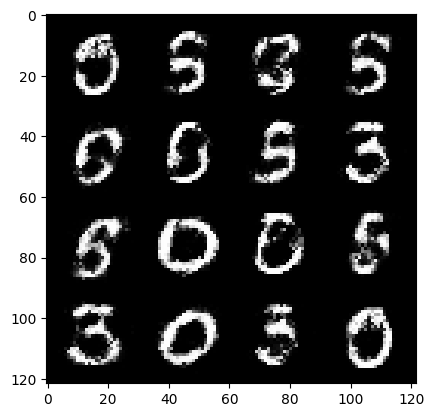

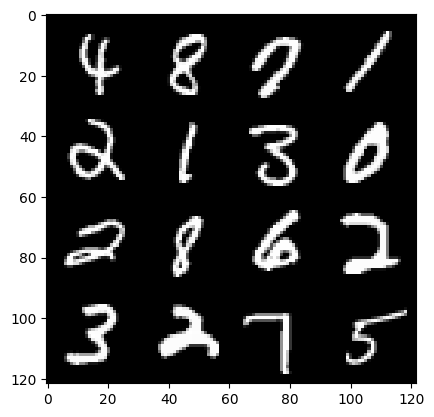

56: step 26700 / Gen loss: 4.48241388320923 / disc_loss: 0.10032358924547828


  0%|          | 0/469 [00:00<?, ?it/s]

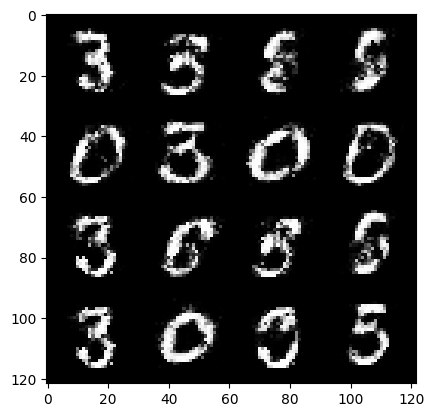

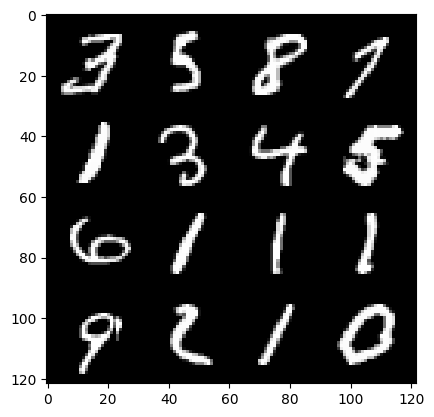

57: step 27000 / Gen loss: 4.451254386107127 / disc_loss: 0.09938137333840119


  0%|          | 0/469 [00:00<?, ?it/s]

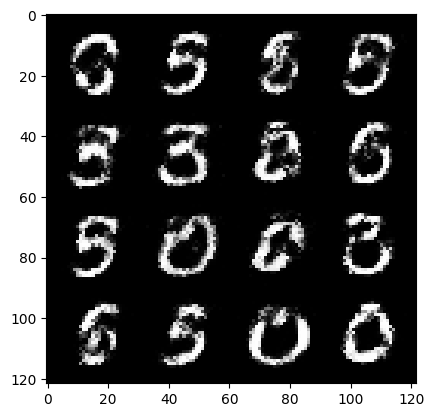

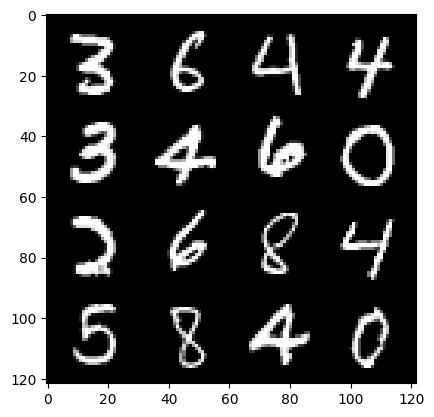

58: step 27300 / Gen loss: 4.415328853925071 / disc_loss: 0.10424641852577526


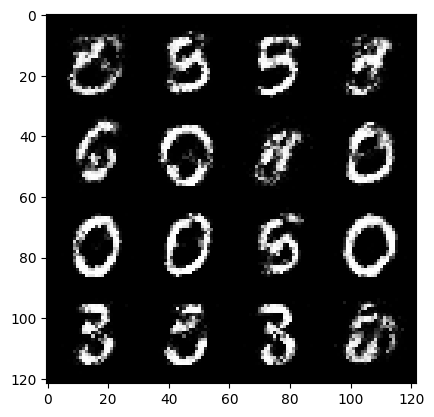

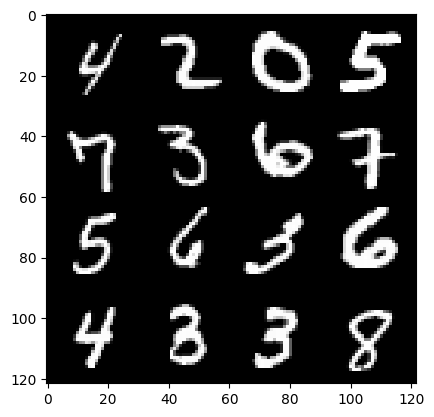

58: step 27600 / Gen loss: 4.424909230073294 / disc_loss: 0.10044547090306878


  0%|          | 0/469 [00:00<?, ?it/s]

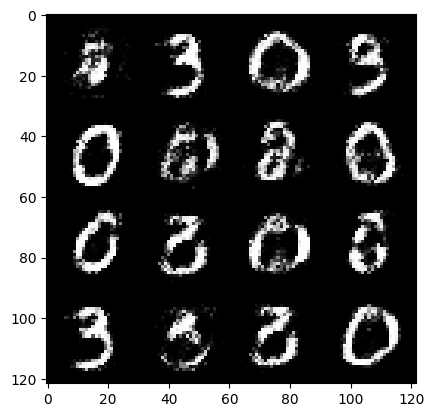

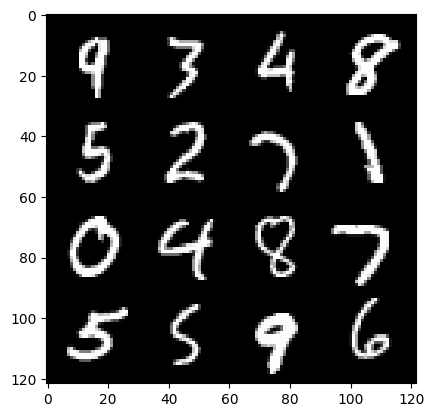

59: step 27900 / Gen loss: 4.679779654343923 / disc_loss: 0.10259556536873186


  0%|          | 0/469 [00:00<?, ?it/s]

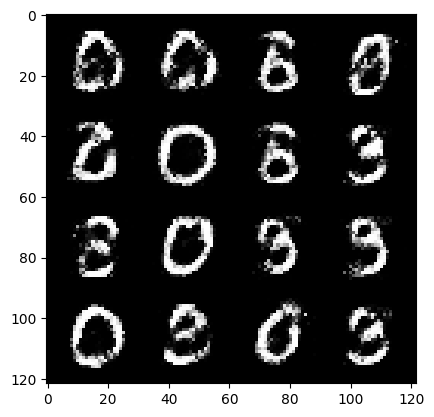

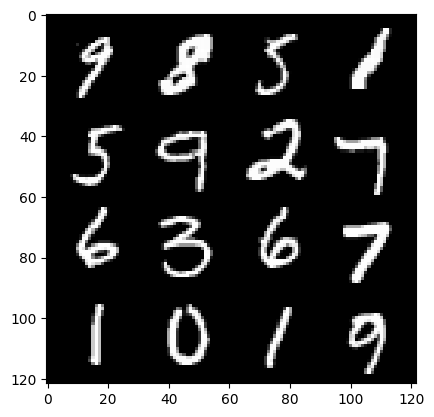

60: step 28200 / Gen loss: 4.307923491795858 / disc_loss: 0.10964763148377339


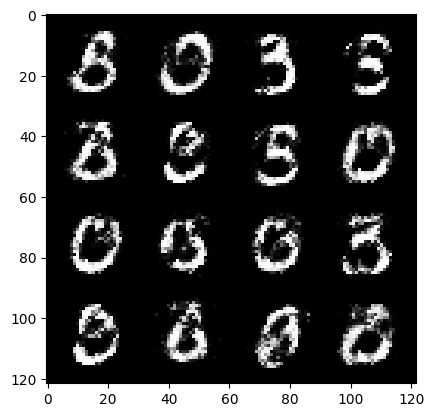

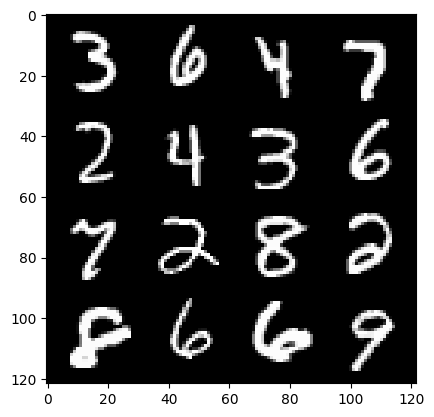

60: step 28500 / Gen loss: 4.428553963502247 / disc_loss: 0.09964981837819016


  0%|          | 0/469 [00:00<?, ?it/s]

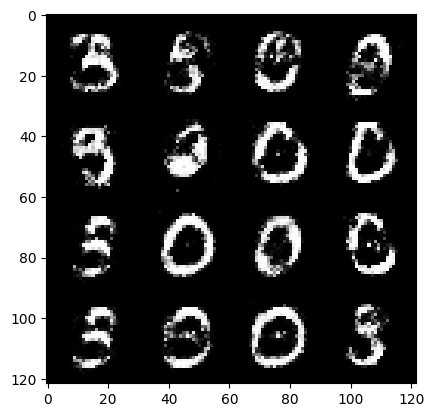

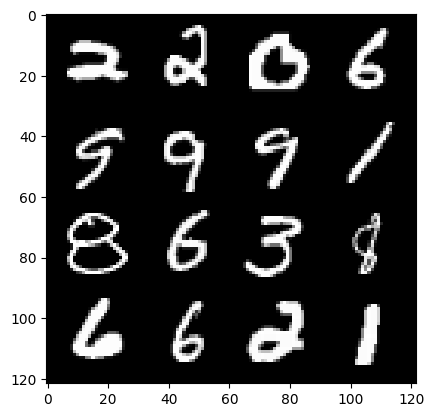

61: step 28800 / Gen loss: 4.229072410265604 / disc_loss: 0.1023588246355454


  0%|          | 0/469 [00:00<?, ?it/s]

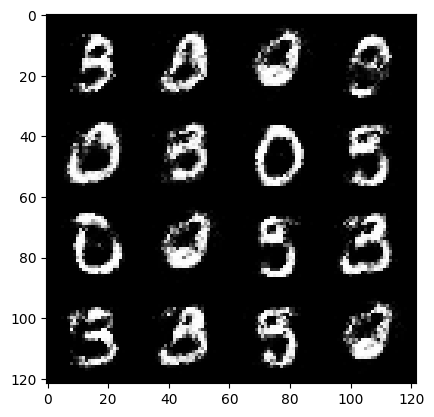

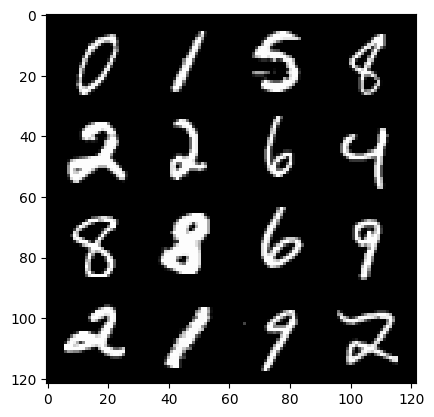

62: step 29100 / Gen loss: 4.352451887130736 / disc_loss: 0.10136739391833552


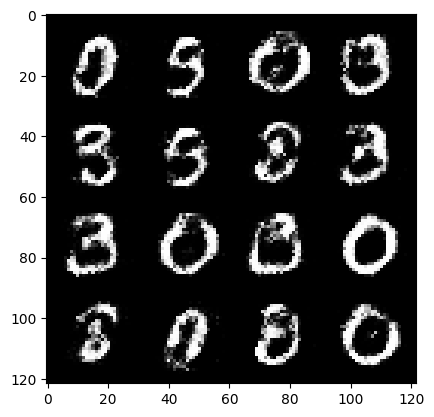

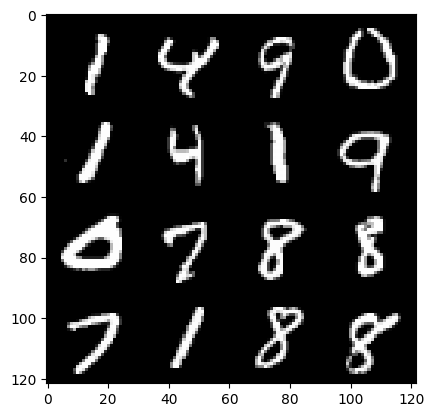

62: step 29400 / Gen loss: 4.318562323252358 / disc_loss: 0.1045187079285581


  0%|          | 0/469 [00:00<?, ?it/s]

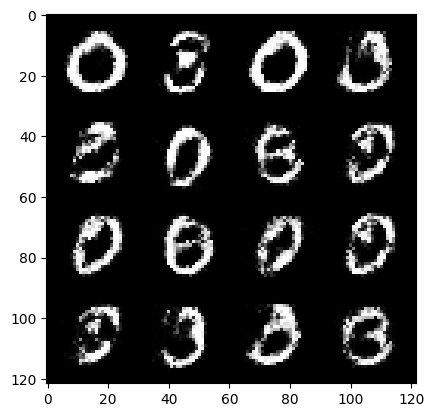

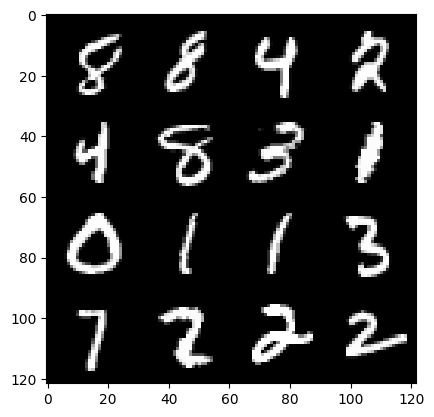

63: step 29700 / Gen loss: 4.3363052177429235 / disc_loss: 0.0977943162744243


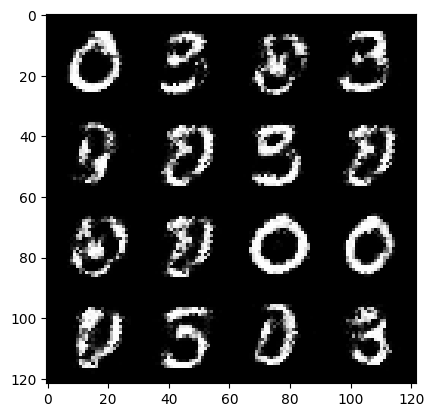

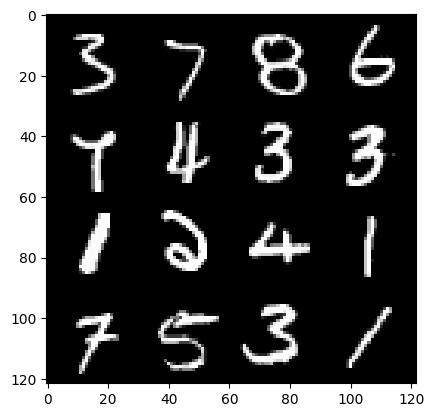

63: step 30000 / Gen loss: 4.240771561463675 / disc_loss: 0.10377674280355376


  0%|          | 0/469 [00:00<?, ?it/s]

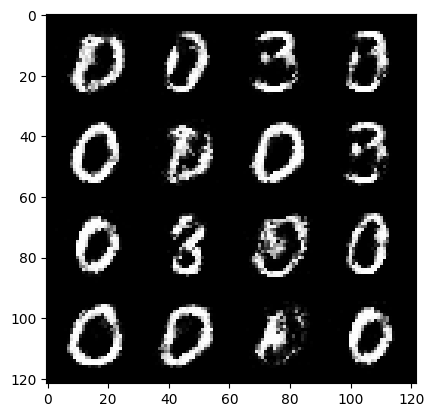

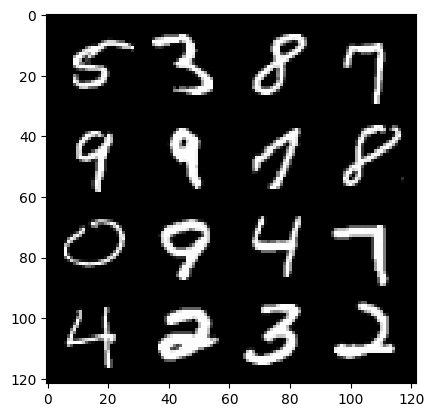

64: step 30300 / Gen loss: 4.23571750164032 / disc_loss: 0.10227793472508594


  0%|          | 0/469 [00:00<?, ?it/s]

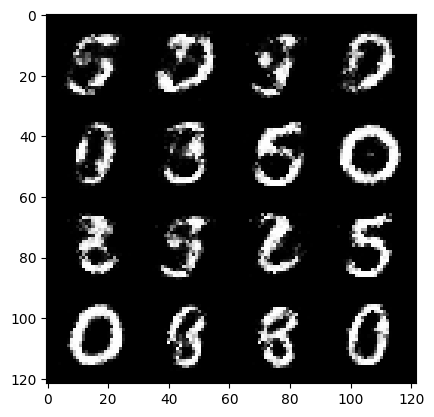

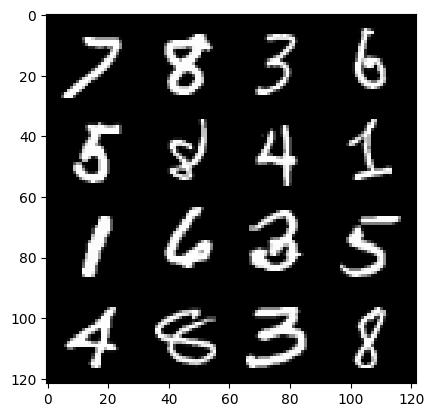

65: step 30600 / Gen loss: 4.357297097841899 / disc_loss: 0.09656378619372838


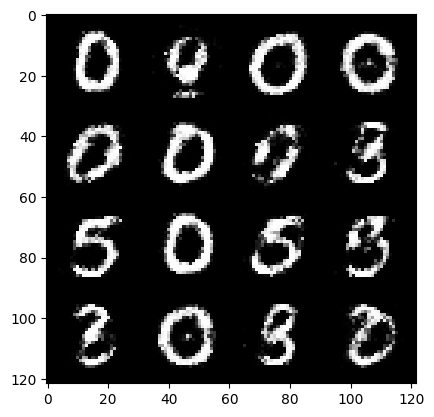

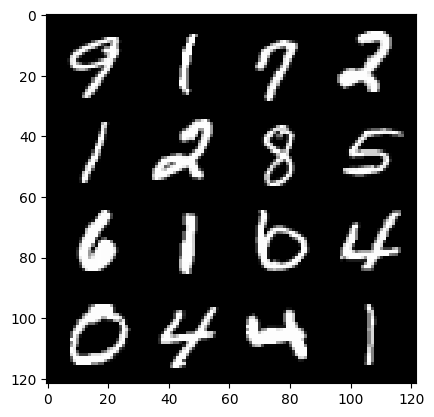

65: step 30900 / Gen loss: 4.362127944628398 / disc_loss: 0.09726746390263231


  0%|          | 0/469 [00:00<?, ?it/s]

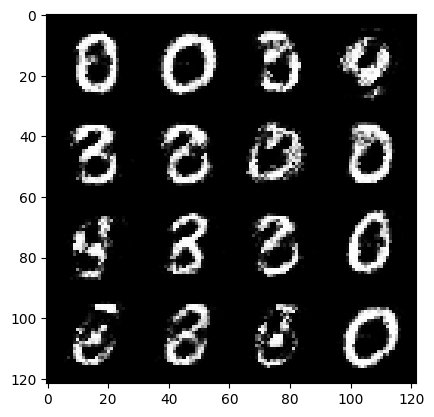

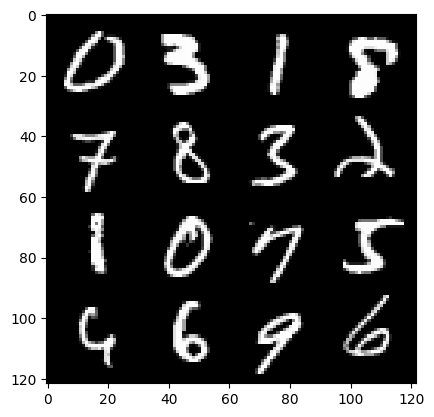

66: step 31200 / Gen loss: 4.167153237660726 / disc_loss: 0.11657656369109948


  0%|          | 0/469 [00:00<?, ?it/s]

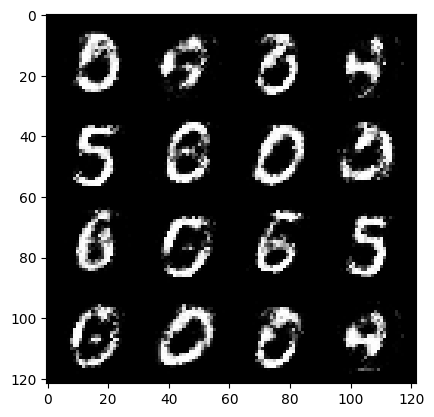

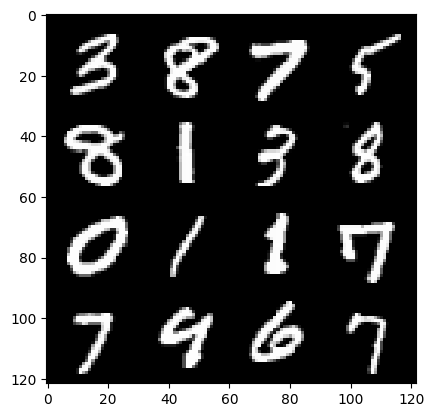

67: step 31500 / Gen loss: 4.163623735904696 / disc_loss: 0.10815714156876004


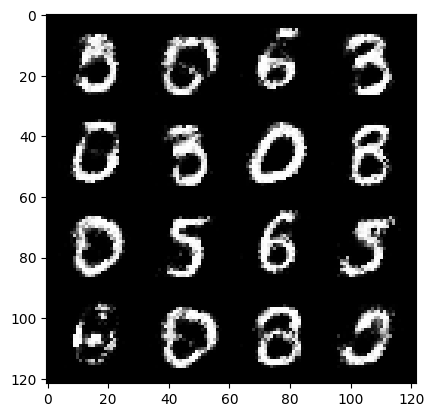

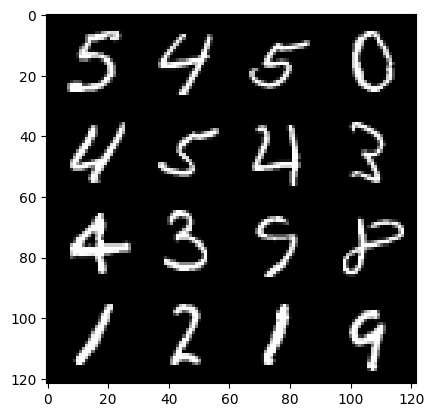

67: step 31800 / Gen loss: 4.1617925143241905 / disc_loss: 0.10608421942840016


  0%|          | 0/469 [00:00<?, ?it/s]

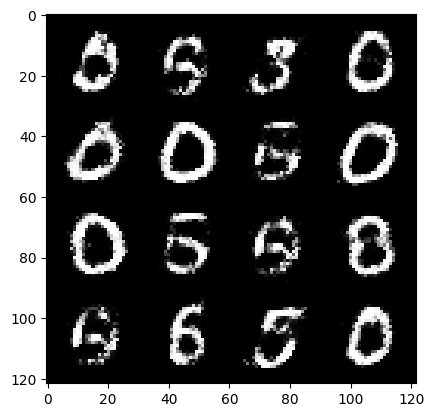

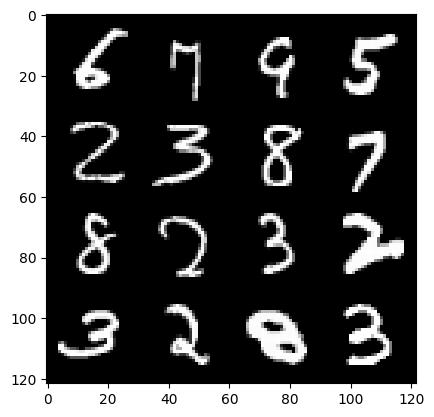

68: step 32100 / Gen loss: 4.168421061833699 / disc_loss: 0.10577679950743912


  0%|          | 0/469 [00:00<?, ?it/s]

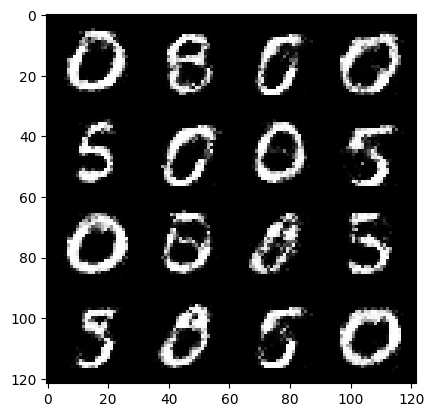

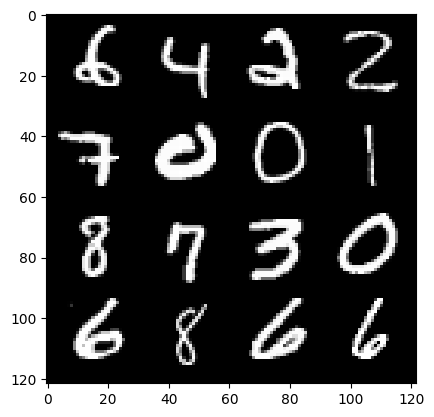

69: step 32400 / Gen loss: 4.0389794810613004 / disc_loss: 0.13069018090764686


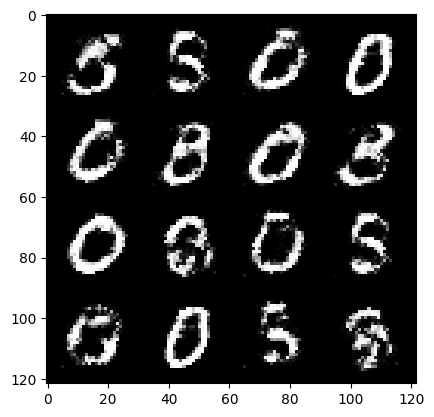

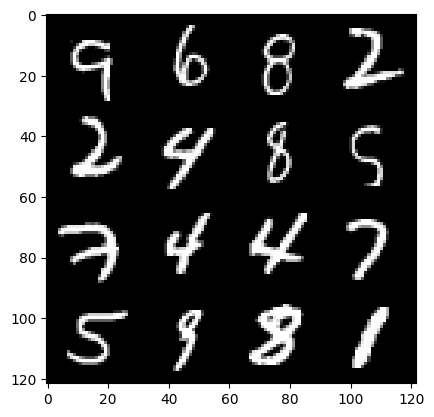

69: step 32700 / Gen loss: 3.8861993869145746 / disc_loss: 0.13269326674441495


  0%|          | 0/469 [00:00<?, ?it/s]

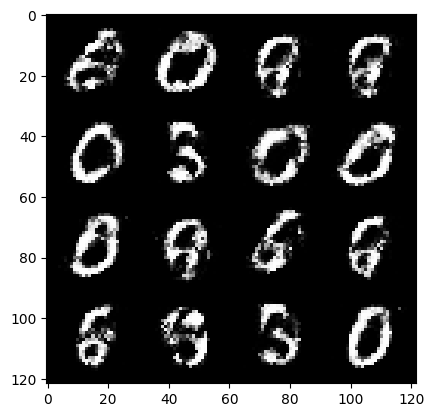

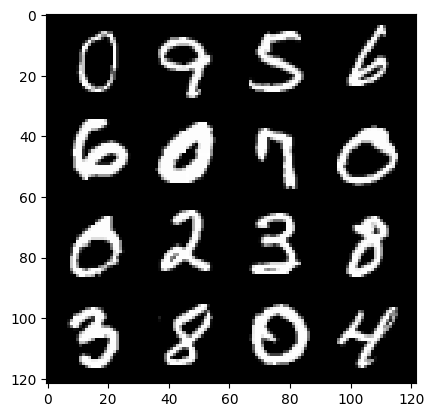

70: step 33000 / Gen loss: 3.9728358459472646 / disc_loss: 0.11961440401772655


  0%|          | 0/469 [00:00<?, ?it/s]

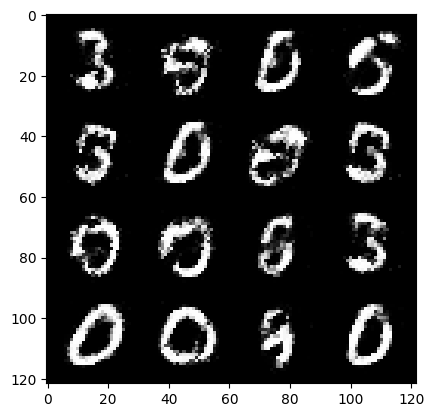

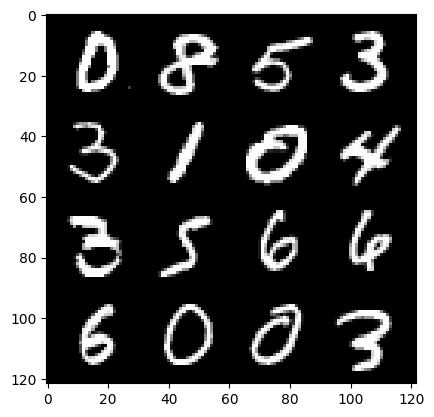

71: step 33300 / Gen loss: 4.068786683877311 / disc_loss: 0.11860887753466767


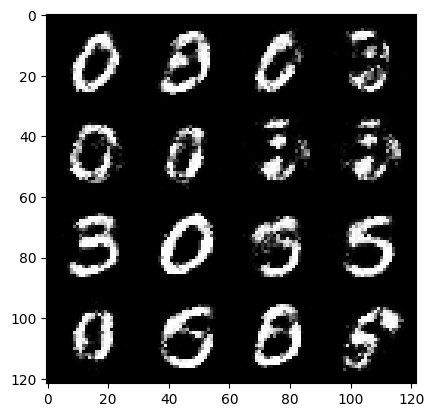

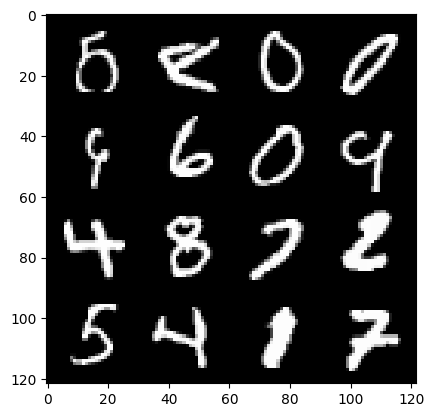

71: step 33600 / Gen loss: 3.954018328189851 / disc_loss: 0.14334395705411832


  0%|          | 0/469 [00:00<?, ?it/s]

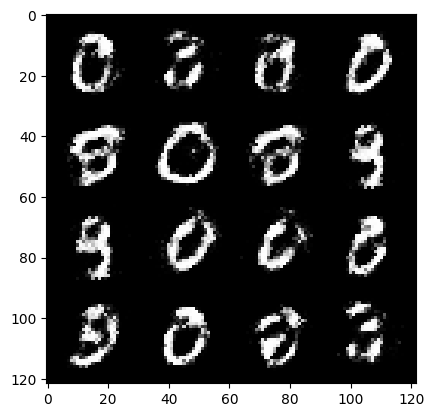

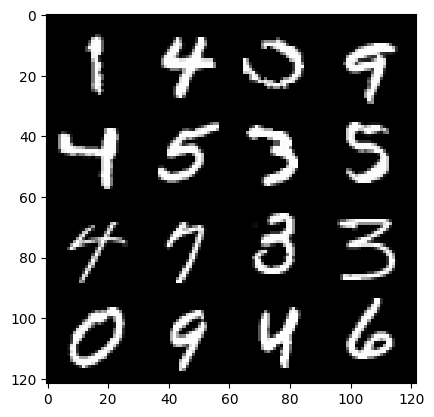

72: step 33900 / Gen loss: 3.753583704630533 / disc_loss: 0.15268838879962765


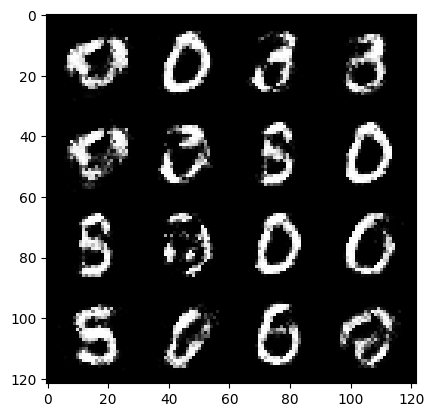

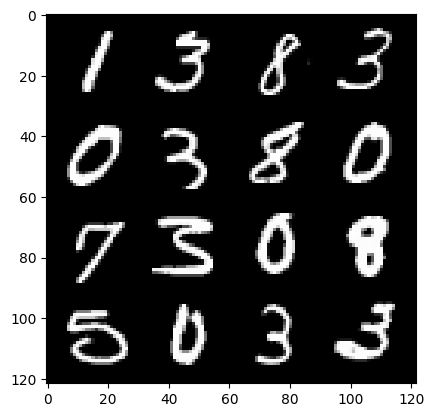

72: step 34200 / Gen loss: 3.750247191588085 / disc_loss: 0.1456065259128809


  0%|          | 0/469 [00:00<?, ?it/s]

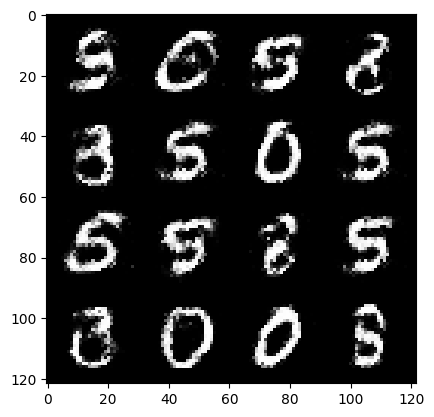

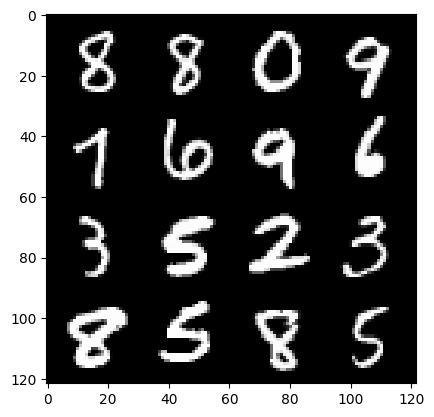

73: step 34500 / Gen loss: 3.8589169049262986 / disc_loss: 0.1330134583512941


  0%|          | 0/469 [00:00<?, ?it/s]

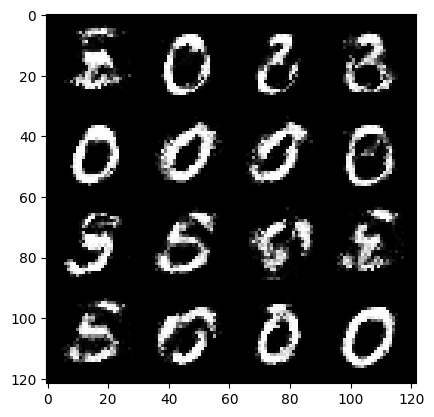

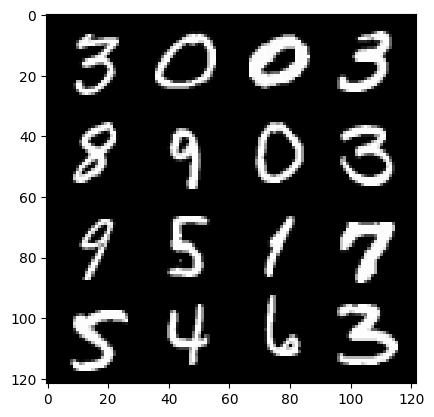

74: step 34800 / Gen loss: 4.039789961179094 / disc_loss: 0.1445201554894446


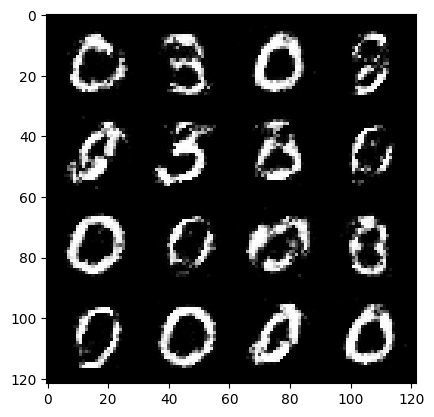

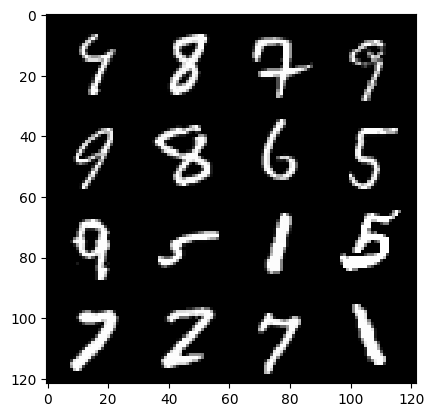

74: step 35100 / Gen loss: 3.8127050375938394 / disc_loss: 0.15954092120130864


  0%|          | 0/469 [00:00<?, ?it/s]

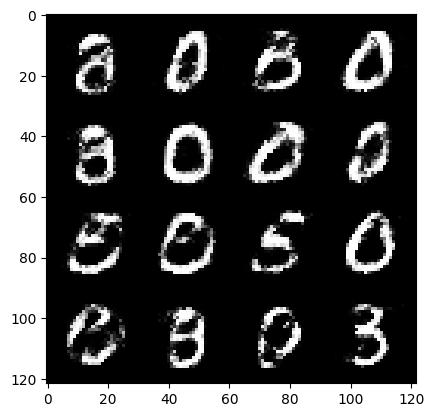

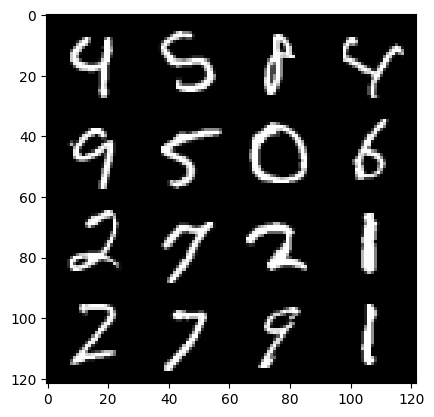

75: step 35400 / Gen loss: 3.8271667313575755 / disc_loss: 0.1369190663223465


  0%|          | 0/469 [00:00<?, ?it/s]

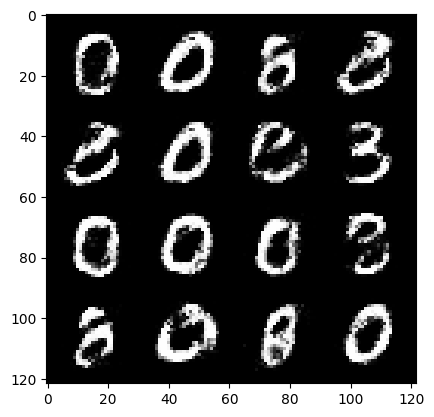

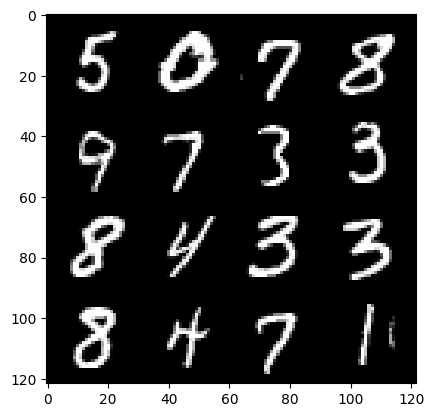

76: step 35700 / Gen loss: 3.6842982721328736 / disc_loss: 0.14800339547296376


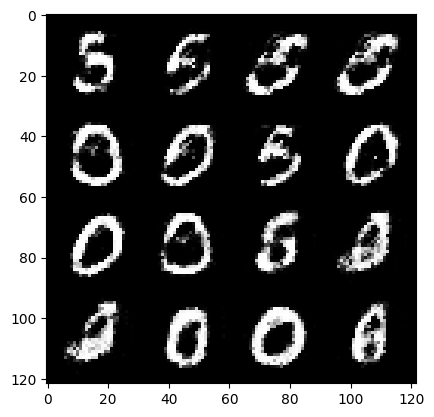

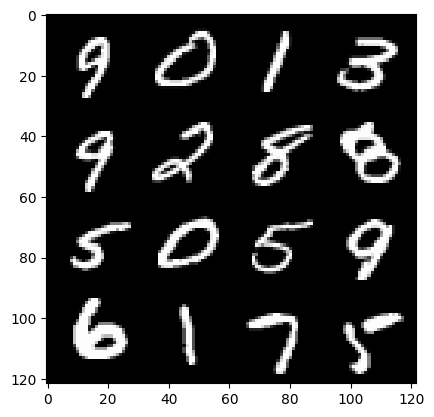

76: step 36000 / Gen loss: 3.8842162434260032 / disc_loss: 0.13026140096286926


  0%|          | 0/469 [00:00<?, ?it/s]

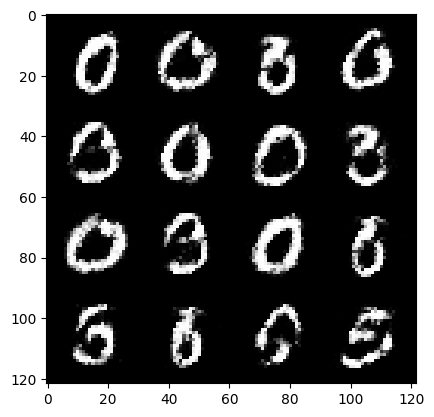

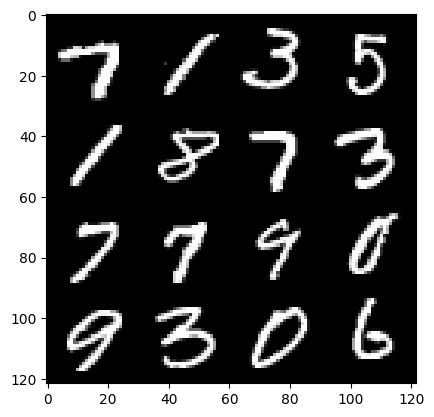

77: step 36300 / Gen loss: 3.5907384936014783 / disc_loss: 0.1517968631039063


  0%|          | 0/469 [00:00<?, ?it/s]

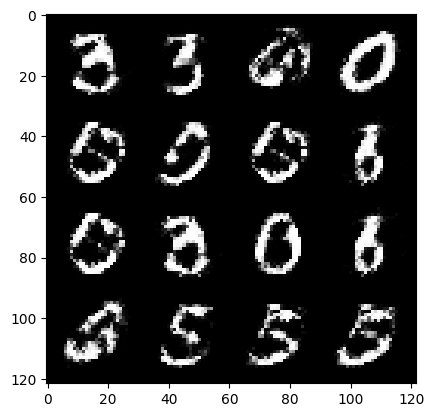

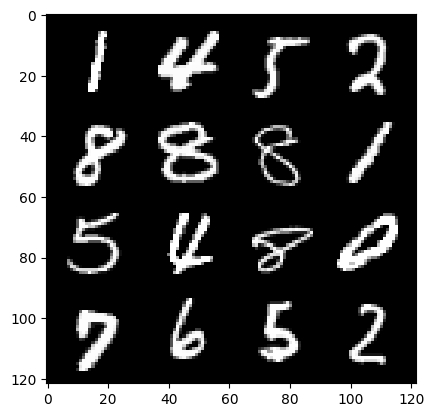

78: step 36600 / Gen loss: 3.598029946486154 / disc_loss: 0.14416608646512025


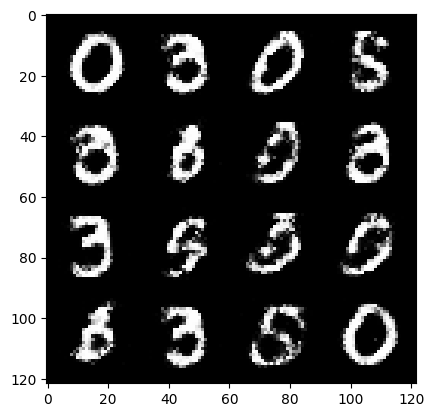

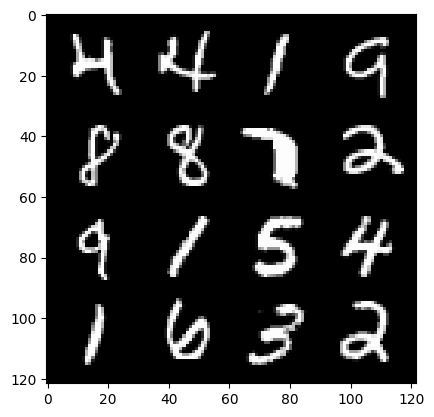

78: step 36900 / Gen loss: 3.780084251562754 / disc_loss: 0.14697328560054312


  0%|          | 0/469 [00:00<?, ?it/s]

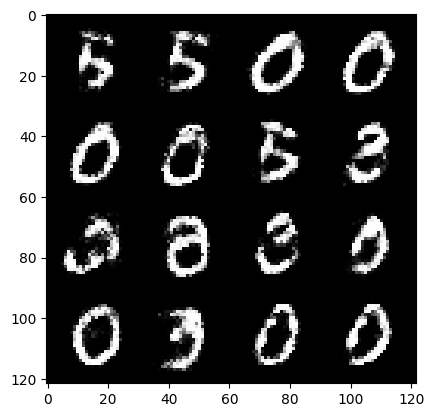

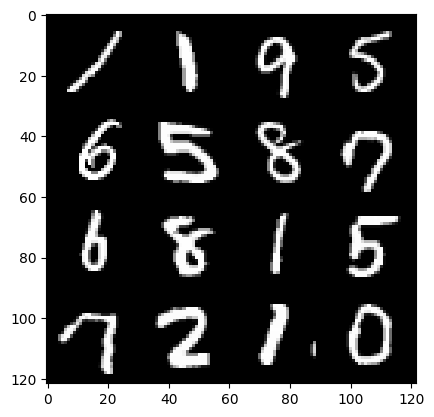

79: step 37200 / Gen loss: 3.605086635748547 / disc_loss: 0.15938631743192683


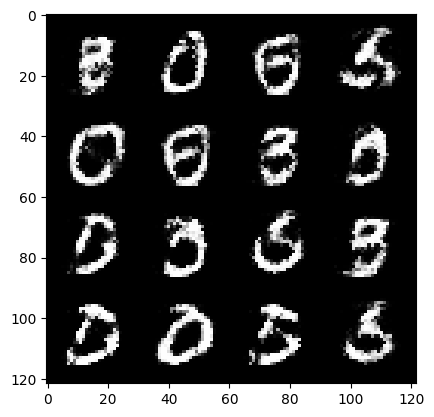

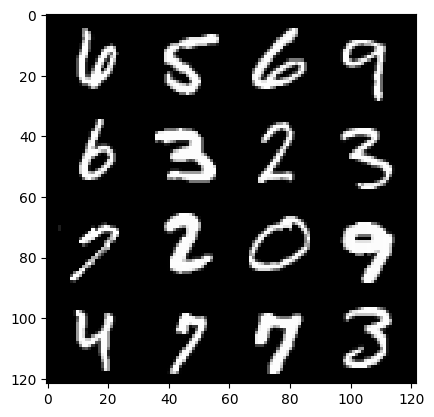

79: step 37500 / Gen loss: 3.5176812537511215 / disc_loss: 0.1463141478349766


  0%|          | 0/469 [00:00<?, ?it/s]

In [ ]:
### 60000 / 128 = 468.75  = 469 steps in each epoch
### Each step is going to process 128 images = size of the batch (except the last step)

for epoch in range(epochs):
  for real, _ in tqdm(dataloader):
    ### discriminator
    disc_opt.zero_grad()

    cur_bs=len(real) # real: 128 x 1 x 28 x 28
    real = real.view(cur_bs, -1) # 128 x 784
    real = real.to(device)

    disc_loss = calc_disc_loss(loss_func,gen,disc,cur_bs,real,z_dim)
    disc_loss.backward(retain_graph=True)
    disc_opt.step()

    ### generator
    gen_opt.zero_grad()
    gen_loss = calc_gen_loss(loss_func,gen,disc,cur_bs,z_dim)
    gen_loss.backward(retain_graph=True)
    gen_opt.step()

    ### visualization & stats
    mean_disc_loss+=disc_loss.item()/info_step
    mean_gen_loss+=gen_loss.item()/info_step

    if cur_step % info_step == 0 and cur_step>0:
      fake_noise = gen_noise(cur_bs, z_dim)
      fake = gen(fake_noise)
      show(fake)
      show(real)
      print(f"{epoch}: step {cur_step} / Gen loss: {mean_gen_loss} / disc_loss: {mean_disc_loss}")
      mean_gen_loss, mean_disc_loss=0,0
    cur_step+=1
